# Analyse factorielle des correspondances

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import sqlite3 as sql

In [2]:
from fanalysis.ca import CA 
from fanalysis.mca import MCA

In [3]:
### Lire le fichier corrigé manuellement – ne pas effacer !

path = 'data/observations_900.csv'

obs = pd.read_csv(path)
obs.set_index('id', inplace=True)
obs.head()

,age,gender,revenu_mensuel,lecture_journal,parti
id,,,,,
1,87,F,9410,trois-quatre fois par semaine,populiste
2,31,H,4466,de temps en temps,gauche
3,79,F,7515,trois-quatre fois par semaine,populiste
4,26,H,3376,le week-end,écologiste
5,75,F,3296,trois-quatre fois par semaine,droite


In [5]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
# et coder les années de naissance en relation avec un découpage significatif au point de vue heuristique, et modifiable si besion
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

generations = [18, 26, 36, 46, 56, 66, 91]
c_obs = obs.copy(deep=True)
c_obs['generation'] = pd.cut(c_obs['age'], generations, right=False)
c_obs['generation'] = c_obs['generation'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))\
       .astype(dtype='str')
# Inspection
c_obs.head()

,age,gender,revenu_mensuel,lecture_journal,parti,generation
id,,,,,,
1,87,F,9410,trois-quatre fois par semaine,populiste,66-90
2,31,H,4466,de temps en temps,gauche,26-35
3,79,F,7515,trois-quatre fois par semaine,populiste,66-90
4,26,H,3376,le week-end,écologiste,26-35
5,75,F,3296,trois-quatre fois par semaine,droite,66-90


In [6]:
max(c_obs['revenu_mensuel'])

265334

In [7]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
# et coder les années de naissance en relation avec un découpage significatif au point de vue heuristique, et modifiable si besion
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

classes_revenu = [0,3000, 4500, 6000, 8000, 10000, 12000, 300000]
c_obs['classe_revenu'] = pd.cut(c_obs['revenu_mensuel'], classes_revenu, right=False)
c_obs['classe_revenu'] = c_obs['classe_revenu']\
    .apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1)).astype(dtype='str')

# Inspection
c_obs.head()

,age,gender,revenu_mensuel,lecture_journal,parti,generation,classe_revenu
id,,,,,,,
1,87,F,9410,trois-quatre fois par semaine,populiste,66-90,8000-9999
2,31,H,4466,de temps en temps,gauche,26-35,3000-4499
3,79,F,7515,trois-quatre fois par semaine,populiste,66-90,6000-7999
4,26,H,3376,le week-end,écologiste,26-35,3000-4499
5,75,F,3296,trois-quatre fois par semaine,droite,66-90,3000-4499


## Age et orientation politique

### Tableau de contingence

In [10]:
### La fonction pivot_table produit un tableau de contingence
## Au centre du tableau se trouvent les effectifs conjoints, 
## aux bords les effectifs marginaux qui correspondent 
## aux distributions indépendantes des variables

X = "parti"  # "0"
Y = "generation"

ddf = c_obs[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

parti,centre,droite,gauche,populiste,écologiste,Total
generation,,,,,,
18-25,6,5,32,22,45,110
26-35,11,14,27,31,46,129
36-45,22,18,18,18,18,94
46-55,33,9,21,36,32,131
56-65,39,17,15,26,26,123
66-90,57,73,39,106,38,313
Total,168,136,152,239,205,900


In [11]:
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

parti,centre,droite,gauche,populiste,écologiste
generation,,,,,
18-25,6,5,32,22,45
26-35,11,14,27,31,46
36-45,22,18,18,18,18
46-55,33,9,21,36,32
56-65,39,17,15,26,26
66-90,57,73,39,106,38


In [12]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 6 , 5 ), effectif: 900 , nombre max. facteurs: 4


In [14]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[:-1,:-1], method='cramer')
print('Cramer: ', vc)

Chi2 : 133.35200723962427 , dof : 20
p-value : 9.136665302058323e-19
phi2 = inertie (variance totale) : 0.14816889693291585
Cramer:  0.20666807779119617


### Commentaire

Noter la petite valeur de p value, on peut rejeter l'hypothèse d'indépendance. 

Le lien n'est pas très fort, mais on profite des axes factoriels pour prendre connaissance des tendances 

In [15]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['centre', 'droite', 'gauche', 'populiste', 'écologiste'], dtype='object', name='parti'),
   row_labels=Index(['18-25', '26-35', '36-45', '46-55', '56-65', '66-90'], dtype='object', name='generation'))

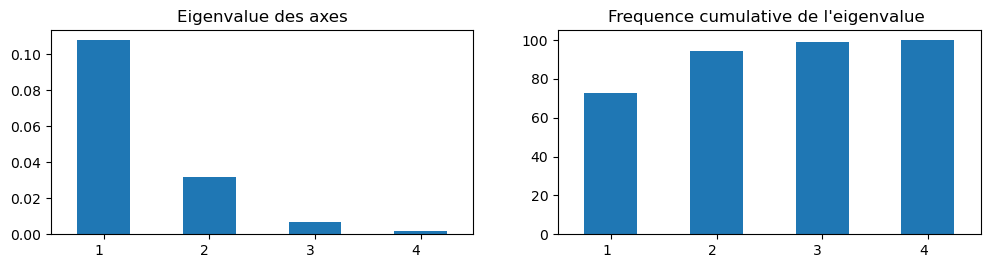

In [16]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Distances des lignes / des colonnes

In [17]:
# Calcul des profils des lignes
prof_lig = np.apply_along_axis(arr=D.values,axis=1,
                               func1d=lambda x:x/np.sum(x))
# Calul du profil marginal correspondant
# Cf. ligne grisée de Figure 100, Rakotomalala, 2020
tot_col = ddf.loc['Total'][:5]
prof_marg_lig = tot_col/np.sum(tot_col)

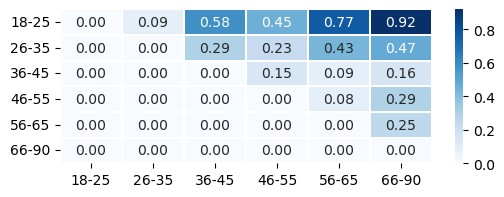

In [18]:
### Distance entre paires de modalités lignes,
# calculée sur la base des valeurs dans la note précédente

fig, ax = plt.subplots(figsize=(6,2))

distPairesLig = np.zeros(shape=(prof_lig.shape[0],prof_lig.shape[0]))
#double boucle
for i in range(prof_lig.shape[0]):
    for j in range(i+1,prof_lig.shape[0]):
        distPairesLig[i,j] = np.sum((prof_lig[i,:]-prof_lig[j,:])**2/prof_marg_lig)

sns.heatmap(distPairesLig,vmin=0,vmax=np.max(distPairesLig),linewidth=0.1,cmap=
'Blues',xticklabels=D.index,yticklabels=D.index,
fmt=".2f", annot=True)


### ATTENTION: plus la couleur est foncée, plus la distance est grande
plt.show()

In [19]:
# Profil marginal des colonnes
tot_lig = np.sum(D.values,axis=1)
prof_marg_col = tot_lig/np.sum(tot_lig)

# Tableau des profils colonnes
prof_col = np.apply_along_axis(arr=D.values,axis=0,
                               func1d=lambda x:x/np.sum(x))
#print(pd.DataFrame(prof_col,index=D.index,columns=D.columns))
### Transposer pour garder la structure du code Python des lignes 
t_prof_col = prof_col.T

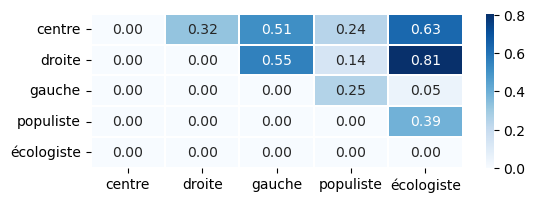

In [20]:
### Distance entre paires de modalités colonnes,
# calculée sur la base des valeurs précédentes  

fig, ax = plt.subplots(figsize=(6,2))


distPairesCol = np.zeros(shape=(t_prof_col.shape[0],
                                t_prof_col.shape[0]))
#double boucle
for i in range(t_prof_col.shape[0]-1):
    for j in range(i+1,t_prof_col.shape[0]):        
        distPairesCol[i,j] = np.sum((t_prof_col[i,:]-t_prof_col[j,:])**2/prof_marg_col)
#distPairesLig[j,i] = distPairesLig[i,j]
#affichage
#print(pd.DataFrame(distPairesLig,index=D.index,columns=D.index))

sns.heatmap(distPairesCol,vmin=0,vmax=np.max(distPairesCol),
            linewidth=0.1,cmap='Blues',xticklabels=D.columns,
            yticklabels=D.columns, 
fmt=".2f", annot=True)

plt.show()

### Graphiques et interprétation du premier plan factoriel

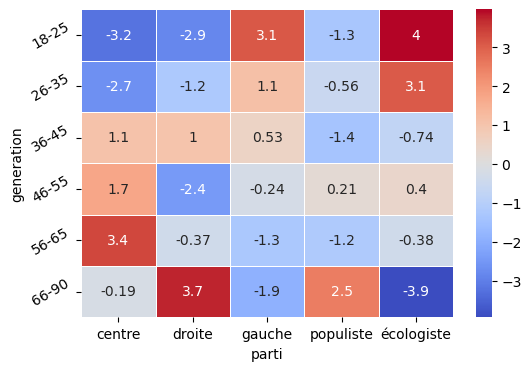

In [21]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = residus_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()


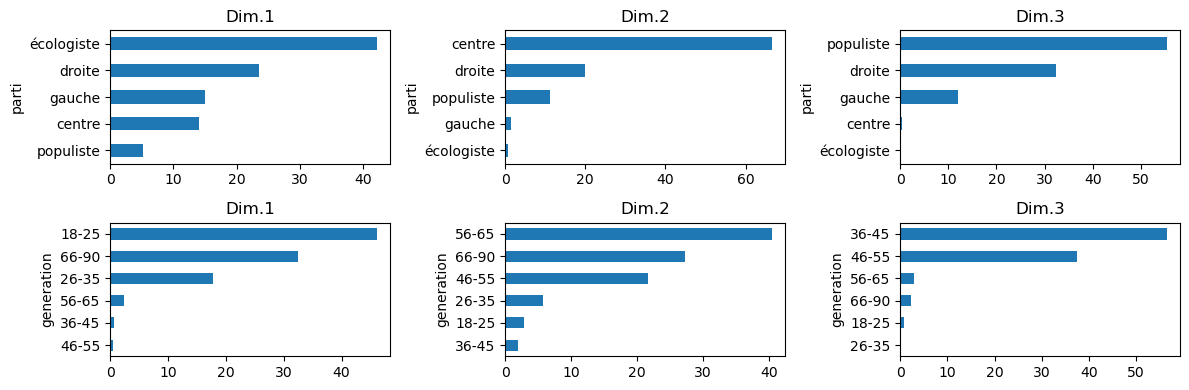

In [30]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Rows
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()


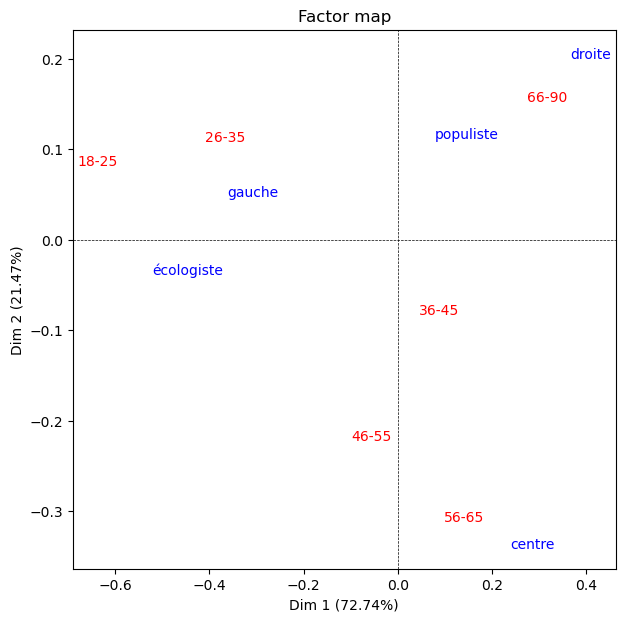

In [31]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

### Représenter l'autre plan factoriel

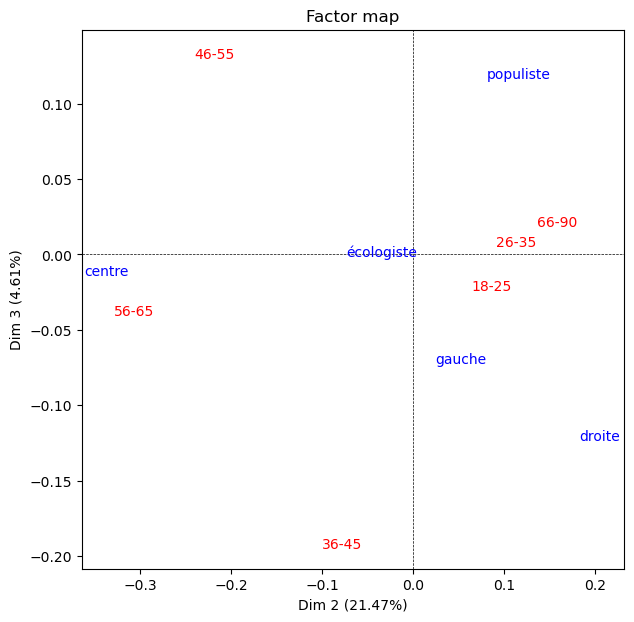

In [32]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(7,7))

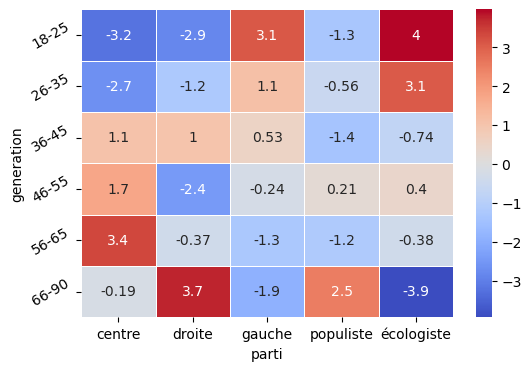

In [33]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = residus_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()


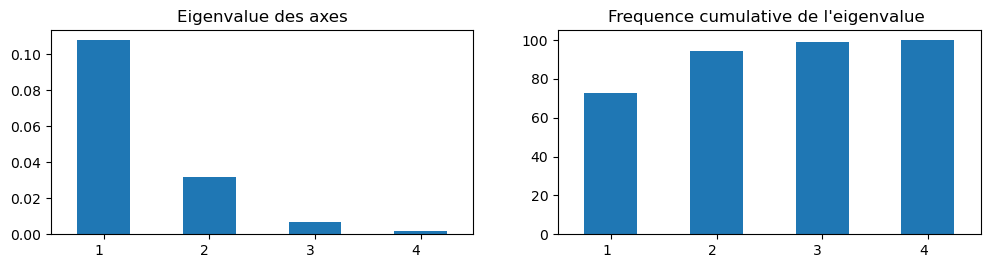

In [ ]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

---------

## Genre et orientation politique

In [34]:
X = "gender"
Y = "parti"  # "0"

ddf = c_obs[[Y,X]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int) 
ddf

parti,centre,droite,gauche,populiste,écologiste,Total
gender,,,,,,
F,100,73,97,97,129,496
H,68,63,55,142,76,404
Total,168,136,152,239,205,900


In [35]:
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

parti,centre,droite,gauche,populiste,écologiste
gender,,,,,
F,100,73,97,97,129
H,68,63,55,142,76


In [36]:
## Nombre de modalités ligne, 
# variable: catégories socio-professionnelles des parents
K = D.shape[0]
## Nombre de modalités colonnes,
# variable : filière d'études chosie
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 2 , 5 ), effectif: 900 , nombre max. facteurs: 1


In [37]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 31.53612635163596 , dof : 4
p-value : 2.3795787064541495e-06
phi2 = inertie (variance totale) : 0.035040140390706624
Cramer:  0.1871901183041098


In [38]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['centre', 'droite', 'gauche', 'populiste', 'écologiste'], dtype='object', name='parti'),
   row_labels=Index(['F', 'H'], dtype='object', name='gender'))

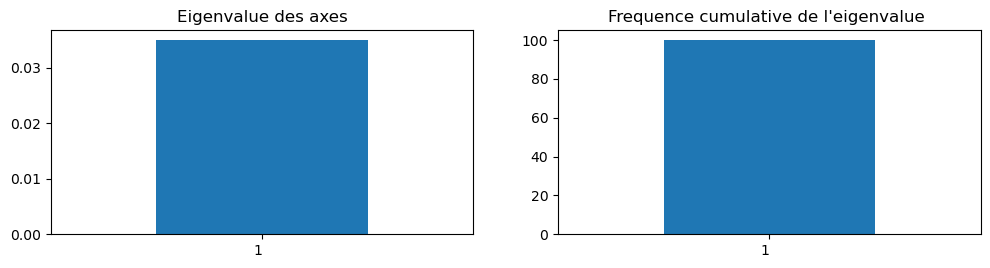

In [39]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Commentaire

Pas la peine de poursuivre, seulement deux modalités pour la variable genre, et un seul axe factoriel

--------

## Orientation politique et fréquence de lecture du journal

In [58]:
X = "parti"  # "0"
Y = "lecture_journal"

ddf = c_obs[[Y,X]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int) 
ddf

lecture_journal,de temps en temps,le week-end,tous les jours,trois-quatre fois par semaine,très rarement,Total
parti,,,,,,
centre,22,45,51,35,15,168
droite,10,22,54,45,5,136
gauche,27,30,38,28,29,152
populiste,62,45,26,49,57,239
écologiste,17,67,63,39,19,205
Total,138,209,232,196,125,900


In [59]:
ddf = ddf[['très rarement', 'de temps en temps', 'le week-end', 'trois-quatre fois par semaine', 'tous les jours','Total']]
ddf.columns = ['0 très rar', '1 de temps', '2 week-end', '3 trois-quatre', '4 tous les','Total']
ddf

,0 très rar,1 de temps,2 week-end,3 trois-quatre,4 tous les,Total
parti,,,,,,
centre,15,22,45,35,51,168
droite,5,10,22,45,54,136
gauche,29,27,30,28,38,152
populiste,57,62,45,49,26,239
écologiste,19,17,67,39,63,205
Total,125,138,209,196,232,900


In [60]:
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

,0 très rar,1 de temps,2 week-end,3 trois-quatre,4 tous les
parti,,,,,
centre,15,22,45,35,51
droite,5,10,22,45,54
gauche,29,27,30,28,38
populiste,57,62,45,49,26
écologiste,19,17,67,39,63


In [61]:
## Nombre de modalités ligne, 
# variable: catégories socio-professionnelles des parents
K = D.shape[0]
## Nombre de modalités colonnes,
# variable : filière d'études chosie
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 5 , 5 ), effectif: 900 , nombre max. facteurs: 4


In [62]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[:-1,:-1], method='cramer')
print('Cramer: ', vc)

Chi2 : 125.7262615679342 , dof : 16
p-value : 4.320810113596032e-19
phi2 = inertie (variance totale) : 0.13969584618659356
Cramer:  0.18829342612109284


In [63]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['0 très rar', '1 de temps', '2 week-end', '3 trois-quatre',
       '4 tous les'],
      dtype='object'),
   row_labels=Index(['centre', 'droite', 'gauche', 'populiste', 'écologiste'], dtype='object', name='parti'))

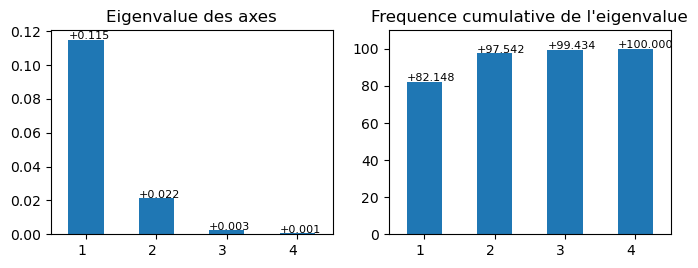

In [132]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
aa = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
for p in aa.patches:
    b = p.get_bbox()
    # print(b)
    val = "{:+.3f}".format(b.y1 + b.y0)    
    # print(b.x1)    
    aa.annotate(val, (b.x0 , b.y1* 1.005), size=8)
plt.margins(y = 0.1)

bb = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue")

for container in bb.containers:
    for p in bb.patches:
        b = p.get_bbox()
        # print(b)
        val = "{:+.3f}".format(b.y1 + b.y0)    
        # print(b.x1)    
        bb.annotate(val, (b.x0, b.y1* 1.005), size=8)


plt.margins(y = 0.1)
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Distances des lignes / des colonnes

In [134]:
# Calcul des profils des lignes
prof_lig = np.apply_along_axis(arr=D.values,axis=1,
                               func1d=lambda x:x/np.sum(x))
# Calul du profil marginal correspondant
# Cf. ligne grisée de Figure 100, Rakotomalala, 2020
tot_col = ddf.loc['Total'][:5]
prof_marg_lig = tot_col/np.sum(tot_col)

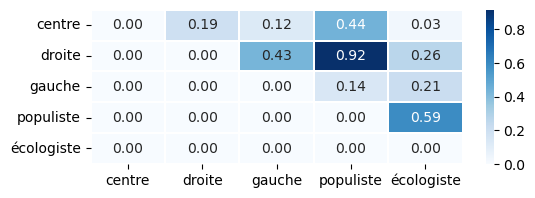

In [135]:
### Distance entre paires de modalités lignes,
# calculée sur la base des valeurs dans la note précédente

fig, ax = plt.subplots(figsize=(6,2))

distPairesLig = np.zeros(shape=(prof_lig.shape[0],prof_lig.shape[0]))
#double boucle
for i in range(prof_lig.shape[0]):
    for j in range(i+1,prof_lig.shape[0]):
        distPairesLig[i,j] = np.sum((prof_lig[i,:]-prof_lig[j,:])**2/prof_marg_lig)

sns.heatmap(distPairesLig,vmin=0,vmax=np.max(distPairesLig),linewidth=0.1,cmap=
'Blues',xticklabels=D.index,yticklabels=D.index,
fmt=".2f", annot=True)


### ATTENTION: plus la couleur est foncée, plus la distance est grande
plt.show()

In [136]:
# Profil marginal des filières (colonnes)
tot_lig = np.sum(D.values,axis=1)
prof_marg_col = tot_lig/np.sum(tot_lig)

# Tableau des profils colonnes
prof_col = np.apply_along_axis(arr=D.values,axis=0,
                               func1d=lambda x:x/np.sum(x))
#print(pd.DataFrame(prof_col,index=D.index,columns=D.columns))
### Transposer pour garder la structure du code Python des lignes 
t_prof_col = prof_col.T

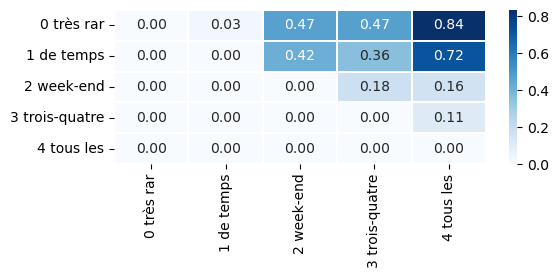

In [137]:
### Distance entre paires de modalités colonnes,
# calculée sur la base des valeurs précédentes  

fig, ax = plt.subplots(figsize=(6,2))


distPairesCol = np.zeros(shape=(t_prof_col.shape[0],
                                t_prof_col.shape[0]))
#double boucle
for i in range(t_prof_col.shape[0]-1):
    for j in range(i+1,t_prof_col.shape[0]):        
        distPairesCol[i,j] = np.sum((t_prof_col[i,:]-t_prof_col[j,:])**2/prof_marg_col)
#distPairesLig[j,i] = distPairesLig[i,j]
#affichage
#print(pd.DataFrame(distPairesLig,index=D.index,columns=D.index))

sns.heatmap(distPairesCol,vmin=0,vmax=np.max(distPairesCol),
            linewidth=0.1,cmap='Blues',xticklabels=D.columns,
            yticklabels=D.columns, 
fmt=".2f", annot=True)

plt.show()

### Graphiques et interprétation du premier plan factoriel

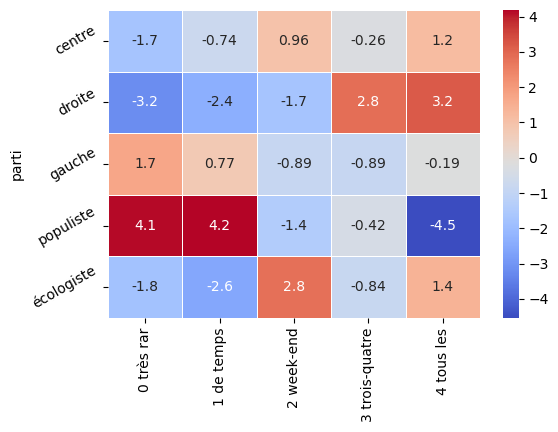

In [138]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = residus_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()


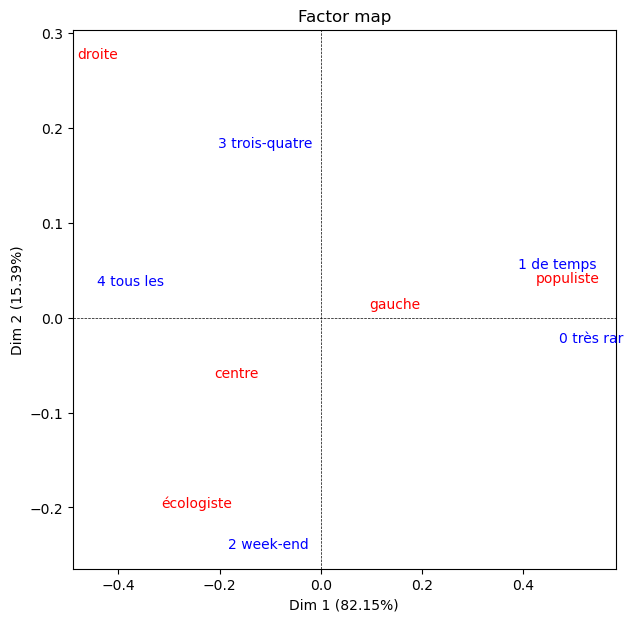

In [205]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

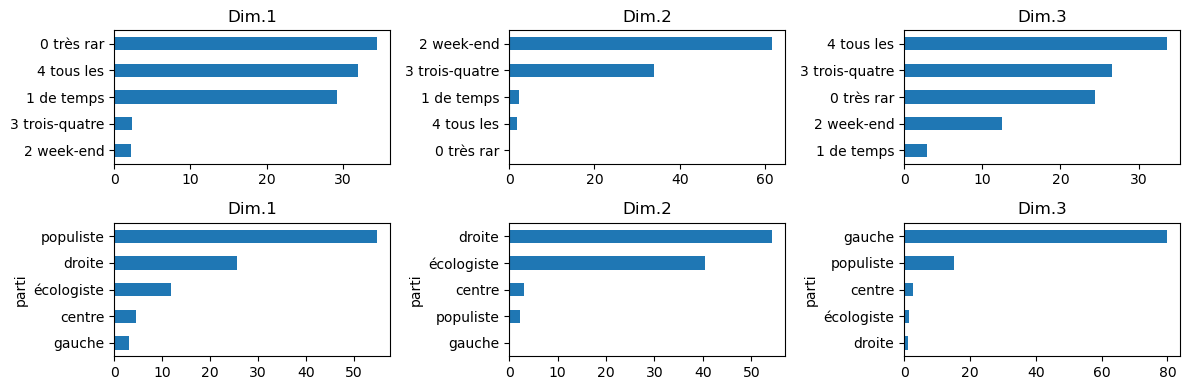

In [140]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Rows
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()


# Analyse factorielle des correspondances multiples

In [295]:
# Inspection
c_obs
c_obs.head()

,age,gender,revenu_mensuel,lecture_journal,parti,generation,classe_revenu
id,,,,,,,
1,87,F,9410,trois-quatre fois par semaine,populiste,66-90,8000-9999
2,31,H,4466,de temps en temps,gauche,26-35,3000-4499
3,79,F,7515,trois-quatre fois par semaine,populiste,66-90,6000-7999
4,26,H,3376,le week-end,écologiste,26-35,3000-4499
5,75,F,3296,trois-quatre fois par semaine,droite,66-90,3000-4499


In [296]:
c_obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 1 to 900
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              900 non-null    int64 
 1   gender           900 non-null    object
 2   revenu_mensuel   900 non-null    int64 
 3   lecture_journal  900 non-null    object
 4   parti            900 non-null    object
 5   generation       900 non-null    object
 6   classe_revenu    900 non-null    object
dtypes: int64(2), object(5)
memory usage: 88.5+ KB


In [297]:
c_obs.columns.values[[1,3,5,4]]  # 4,6 !

array(['gender', 'lecture_journal', 'generation', 'parti'], dtype=object)

In [298]:
DActives = c_obs[c_obs.columns.values[[1,3,5,4]]]
DActives.head()

,gender,lecture_journal,generation,parti
id,,,,
1,F,trois-quatre fois par semaine,66-90,populiste
2,H,de temps en temps,26-35,gauche
3,F,trois-quatre fois par semaine,66-90,populiste
4,H,le week-end,26-35,écologiste
5,F,trois-quatre fois par semaine,66-90,droite


In [263]:
#Rcupération des infos - nombre de variables
p = DActives.shape[1]
#nombre d'observations
n = DActives.shape[0]
print('Nombre variables:', p, 'Nombre lignes:', n)
#codage en 0/1
X = pd.get_dummies(DActives,prefix='',prefix_sep='')*1
X.head()

Nombre variables: 4 Nombre lignes: 900


,F,H,de temps en temps,le week-end,tous les jours,trois-quatre fois par semaine,très rarement,18-25,26-35,36-45,46-55,56-65,66-90,centre,droite,gauche,populiste,écologiste
id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
4,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
5,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0


In [265]:
### Nombre total de modalités, toute variable confondue
M = X.shape[1]
print('Nombre de modalités:', M)
#nombre max de facteurs
Hmax = M-p
print('Nombre maximal de facteurs:', Hmax)

Nombre de modalités: 18
Nombre maximal de facteurs: 14


In [260]:
Xm = X.copy(deep=True)
#Total sum per row: 
Xm.loc[:,'Total'] = Xm.sum(axis=1)
#Total sum per column: 
Xm.loc['Total',:] = Xm.sum(axis=0)
Xm.tail()

,F,H,de temps en temps,le week-end,tous les jours,trois-quatre fois par semaine,très rarement,18-25,26-35,36-45,46-55,56-65,66-90,centre,droite,gauche,populiste,écologiste,Total
id,,,,,,,,,,,,,,,,,,,
897,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0
898,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
899,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
900,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0
Total,496.0,404.0,138.0,209.0,232.0,196.0,125.0,110.0,129.0,94.0,131.0,123.0,313.0,168.0,136.0,152.0,239.0,205.0,3600.0


In [262]:
#Profil individu moyen
ind_moy = np.sum(X.values,axis=0)/(n*p)
print(ind_moy)

[0.13777778 0.11222222 0.03833333 0.05805556 0.06444444 0.05444444
 0.03472222 0.03055556 0.03583333 0.02611111 0.03638889 0.03416667
 0.08694444 0.04666667 0.03777778 0.04222222 0.06638889 0.05694444]


In [266]:
### Ajouter une colonne avec la distance de l'individu moyen
# pour chaque individu: les individus plus éloignés sont plus rares
X['dist_org'] = X.apply(lambda x: round(np.sum(1/ind_moy*(x/p-ind_moy)**2),4), raw=True, axis=1)
X['dist_org']

id
1      2.2619
2      4.4118
3      2.2619
4      3.4752
5      2.9748
        ...  
896    4.0525
897    2.8007
898    3.6698
899    3.6987
900    2.2938
Name: dist_org, Length: 900, dtype: float64

count    900.000000
mean       3.499997
std        0.690076
min        2.083700
25%        2.974800
50%        3.528400
75%        4.010400
max        5.235400
Name: dist_org, dtype: float64


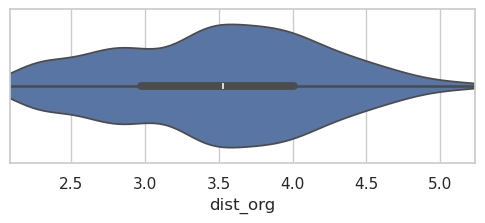

In [268]:

sns.set_theme(style="whitegrid",rc={"figure.figsize":(6,2)} )


a = X['dist_org']

print(a.describe())

# ax = sns.boxplot(x=a)
ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=min(a), right=max(a))

plt.show()

In [293]:
i = X[X.dist_org>5][:10]
i

,F,H,de temps en temps,le week-end,tous les jours,trois-quatre fois par semaine,très rarement,18-25,26-35,36-45,46-55,56-65,66-90,centre,droite,gauche,populiste,écologiste,dist_org
id,,,,,,,,,,,,,,,,,,,
67,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,5.2354
92,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,5.0612
113,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,5.1275
266,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,5.0898
299,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,5.1275
308,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,5.0612
548,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,5.2308
612,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,5.0612
662,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,5.2308


In [305]:
### Individus très distants du profil moyen
#  donc rares
i = X[X.dist_org>4.8]
print(len(i))
c_obs.loc[i[:10].index]

19


,age,gender,revenu_mensuel,lecture_journal,parti,generation,classe_revenu
id,,,,,,,
8,21,H,3338,très rarement,gauche,18-25,3000-4499
58,25,H,3658,très rarement,gauche,18-25,3000-4499
67,37,H,9286,de temps en temps,droite,36-45,8000-9999
92,39,H,5685,de temps en temps,gauche,36-45,4500-5999
113,36,F,6962,très rarement,gauche,36-45,6000-7999
266,36,H,4653,très rarement,centre,36-45,4500-5999
299,39,F,5054,très rarement,gauche,36-45,4500-5999
308,43,H,7225,de temps en temps,gauche,36-45,6000-7999
426,42,F,4257,de temps en temps,gauche,36-45,3000-4499


In [307]:
### Individus proches du profil moyen
#  donc fréquents
i = X[X.dist_org<2.5]
print(len(i))
c_obs.loc[i[:10].index]

91


,age,gender,revenu_mensuel,lecture_journal,parti,generation,classe_revenu
id,,,,,,,
1,87,F,9410,trois-quatre fois par semaine,populiste,66-90,8000-9999
3,79,F,7515,trois-quatre fois par semaine,populiste,66-90,6000-7999
32,80,H,10325,trois-quatre fois par semaine,populiste,66-90,10000-11999
35,75,F,6504,trois-quatre fois par semaine,populiste,66-90,6000-7999
46,68,H,6566,le week-end,populiste,66-90,6000-7999
49,71,F,7810,trois-quatre fois par semaine,populiste,66-90,6000-7999
83,69,F,4401,trois-quatre fois par semaine,populiste,66-90,3000-4499
89,77,F,8493,le week-end,populiste,66-90,8000-9999
91,82,F,5661,tous les jours,centre,66-90,4500-5999


In [308]:
### Individus moyennements distants du profil moyen
i = X[(X.dist_org>3.2) & (X.dist_org <3.7)]
print(len(i))
c_obs.loc[i[:10].index]

249


,age,gender,revenu_mensuel,lecture_journal,parti,generation,classe_revenu
id,,,,,,,
4,26,H,3376,le week-end,écologiste,26-35,3000-4499
9,22,F,2370,tous les jours,écologiste,18-25,0-2999
11,64,H,13895,tous les jours,populiste,56-65,12000-299999
19,65,F,3042,le week-end,écologiste,56-65,3000-4499
20,60,F,4615,le week-end,centre,56-65,4500-5999
21,52,F,9622,le week-end,écologiste,46-55,8000-9999
24,63,H,5119,trois-quatre fois par semaine,populiste,56-65,4500-5999
25,72,F,3506,très rarement,gauche,66-90,3000-4499
26,89,H,6991,de temps en temps,gauche,66-90,6000-7999


## Inspection des modalités

In [286]:
### Profil moyen colonnes
moda_moy = np.ones(X.shape[0])/n
moda_moy[:10]


array([0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111])

In [273]:
#enelver la colonne 'dist-org'
df = X.iloc[:,:-1]
#somme en colonne
somme_col = np.sum(df.values,axis=0)
print(somme_col)
#poids des variables_modalités (points modalités)
poids_moda = somme_col/(n*p)
#distance à l'origine des points modalités
disto_moda = np.apply_along_axis(arr=df.values/somme_col,axis=0,func1d=lambda x:
np.sum(n*(x-moda_moy)**2))
#np
inertie_moda = poids_moda * disto_moda
#affichage
dfc = pd.DataFrame(np.transpose([poids_moda,disto_moda,inertie_moda]),index=df.columns,columns=['Poids','Disto','Inertie'])
dfc

[496 404 138 209 232 196 125 110 129  94 131 123 313 168 136 152 239 205]


,Poids,Disto,Inertie
F,0.137778,0.814516,0.112222
H,0.112222,1.227723,0.137778
de temps en temps,0.038333,5.521739,0.211667
le week-end,0.058056,3.306220,0.191944
tous les jours,0.064444,2.879310,0.185556
trois-quatre fois par semaine,0.054444,3.591837,0.195556
très rarement,0.034722,6.200000,0.215278
18-25,0.030556,7.181818,0.219444
26-35,0.035833,5.976744,0.214167
36-45,0.026111,8.574468,0.223889


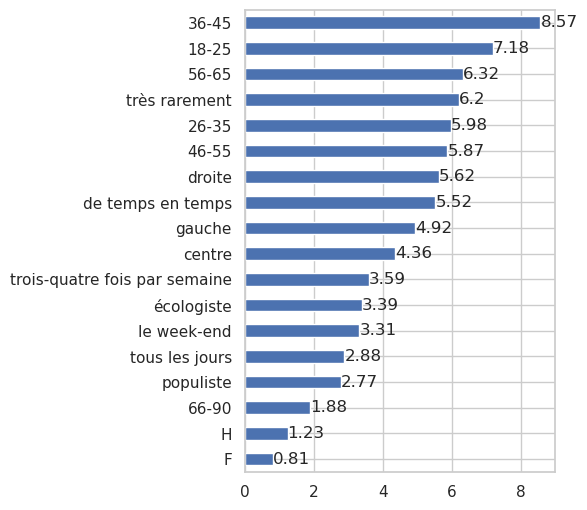

In [285]:
ax = round(dfc.Disto.sort_values(ascending=True),2).plot(kind='barh', 
                    figsize=(4,6))

ax.bar_label(ax.containers[0])

plt.show()

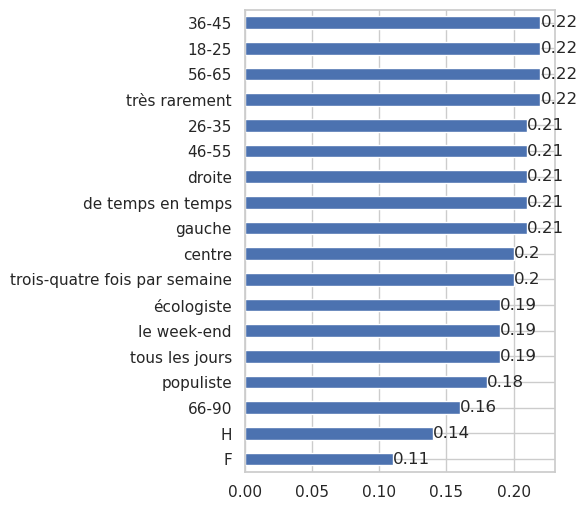

In [309]:
### Modalité qui contribuent le plus à l'inertie
# donc à la variation
ax = round(dfc.Inertie.sort_values(ascending=True),2).plot(kind='barh', 
                    figsize=(4,6))

ax.bar_label(ax.containers[0])

plt.show()

## Représentation graphique

In [310]:
acm = MCA(row_labels=DActives.index,var_labels=DActives.columns)
acm.fit(DActives.values)

MCA(row_labels=Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       891, 892, 893, 894, 895, 896, 897, 898, 899, 900],
      dtype='int64', name='id', length=900),
    var_labels=Index(['gender', 'lecture_journal', 'generation', 'parti'], dtype='object'))

In [311]:
eig = pd.DataFrame(acm.eig_).transpose()
eig.columns=['contribution','freq','freq_cumulee']

eig.head(), eig.tail()


(   contribution       freq  freq_cumulee
 0      0.361539  10.329672     10.329672
 1      0.336567   9.616214     19.945886
 2      0.304328   8.695099     28.640985
 3      0.281255   8.035847     36.676832
 4      0.263939   7.541106     44.217938,
     contribution      freq  freq_cumulee
 9       0.230362  6.581770     78.973772
 10      0.212363  6.067508     85.041280
 11      0.201837  5.766781     90.808062
 12      0.163394  4.668387     95.476449
 13      0.158324  4.523551    100.000000)

In [312]:
### Frequency
eig.iloc[:,1][:5]

0    10.329672
1     9.616214
2     8.695099
3     8.035847
4     7.541106
Name: freq, dtype: float64

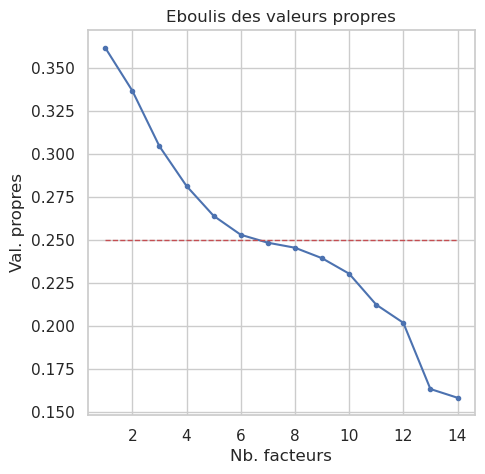

In [313]:
#éboulis des v.p.
fix,ax = plt.subplots(figsize=(5,5))
ax.plot(range(1,Hmax+1),acm.eig_[0],".-")
ax.set_xlabel("Nb. facteurs")
ax.set_ylabel("Val. propres")
plt.title("Eboulis des valeurs propres")
#seuil - Règle de Kaiser
ax.plot([1,Hmax],[1/p,1/p],"r--",linewidth=1)
plt.show()

*Diagramme d'éboulis*. Représentation graphique ayant pour but d'identifier un point d'inflexion dans une courbe de la variance. Le nom donné à ce type de graphique vient de la ressemblance de la courbe avec le profil des éboulis (scree) au bas d'une falaise. [DataFranca, Diagramme d'éboulis, 2024](https://datafranca.org/wiki/index.php?title=Diagramme_d%27%C3%A9boulis&oldid=93502)

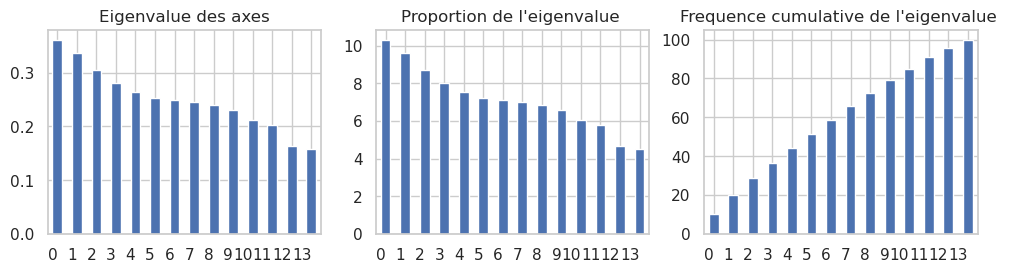

In [314]:
# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

eig.iloc[:,0].plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
eig.iloc[:,1].plot(kind='bar', ax=axes[1], title="Proportion de l'eigenvalue ")
eig.iloc[:,2].plot(kind='bar', ax=axes[2], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

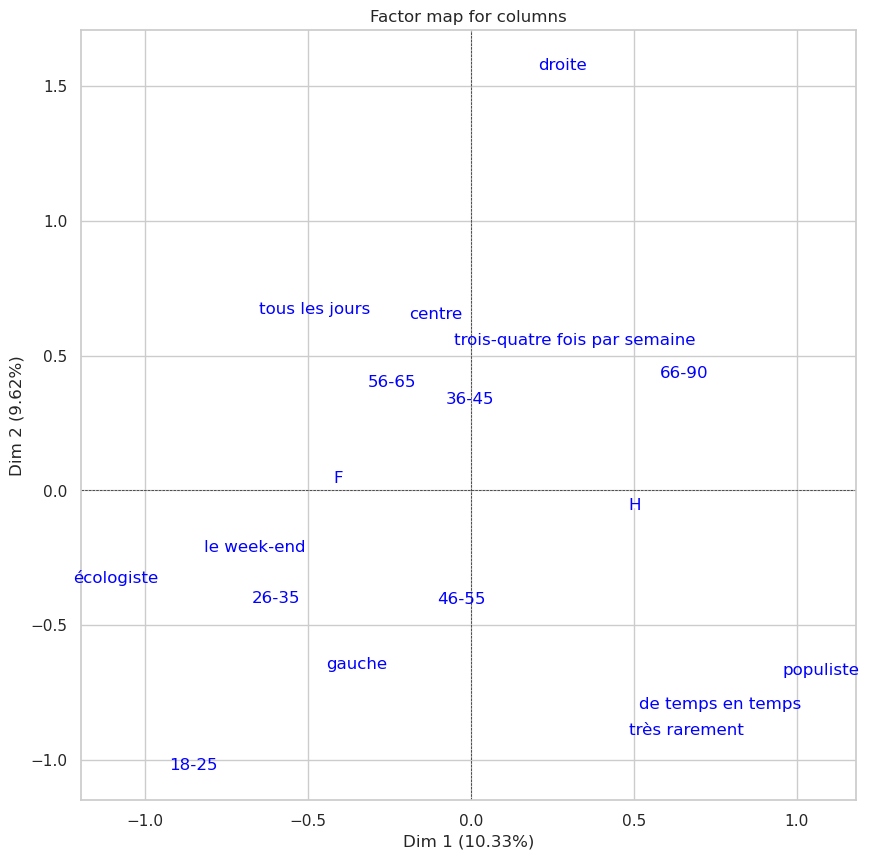

In [325]:
# Mapping des points colonnes
acm.mapping_col(num_x_axis=1, num_y_axis=2, figsize=(10,10))

In [351]:
### Correction de Benzecri, cf. Rakotomalala, Pratique, p.313sqq

#somme en colonne
#récupérer les valeurs propres supérieur à (1/p)
lambada = acm.eig_[0][acm.eig_[0]>1/p]
print(lambada)

#appliquer la correction
lambada_prim = ((p/(p-1))*(lambada-1/p))**2
print(lambada_prim)

#faire la somme
S_prim = np.sum(lambada_prim)
print('u',S_prim)

#et produire les pourcentages
percent_prim = lambada_prim/S_prim*100

#affichage
dfb = pd.DataFrame(np.transpose(np.array([lambada_prim,percent_prim,
                                np.cumsum(percent_prim)])),columns=['Val.P','freq','Cumul_freq'],
                                index=range(1,len(percent_prim)+1))
print(dfb)

[0.36153852 0.33656749 0.30432847 0.28125464 0.26393872 0.25296497]
[2.21170495e-02 1.33225425e-02 5.24725883e-03 1.73662670e-03
 3.45400813e-04 1.56285334e-05]
u 0.04278450693859425
      Val.P       freq  Cumul_freq
1  0.022117  51.694062   51.694062
2  0.013323  31.138708   82.832770
3  0.005247  12.264390   95.097160
4  0.001737   4.059008   99.156168
5  0.000345   0.807303   99.963472
6  0.000016   0.036528  100.000000


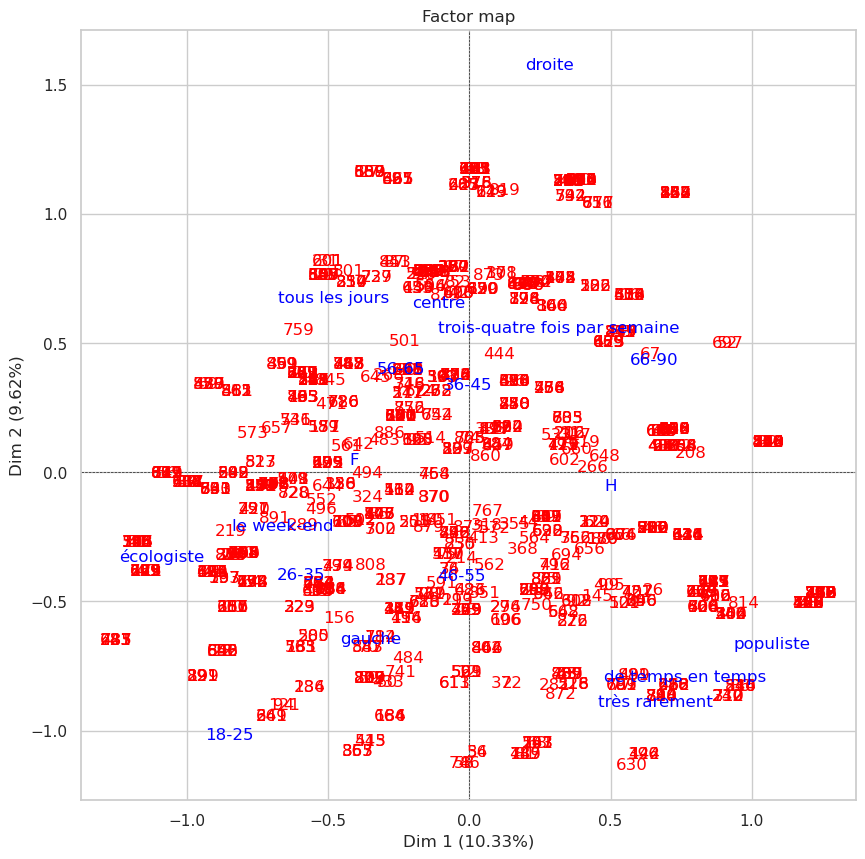

In [346]:
# Mapping simultané des points lignes et colonnes
# Les paramètres de la méthode mapping indiquent que ce sont les axes 1 et 2 qui sont ici représentés
acm.mapping(num_x_axis=1, num_y_axis=2, figsize=(10,10), )

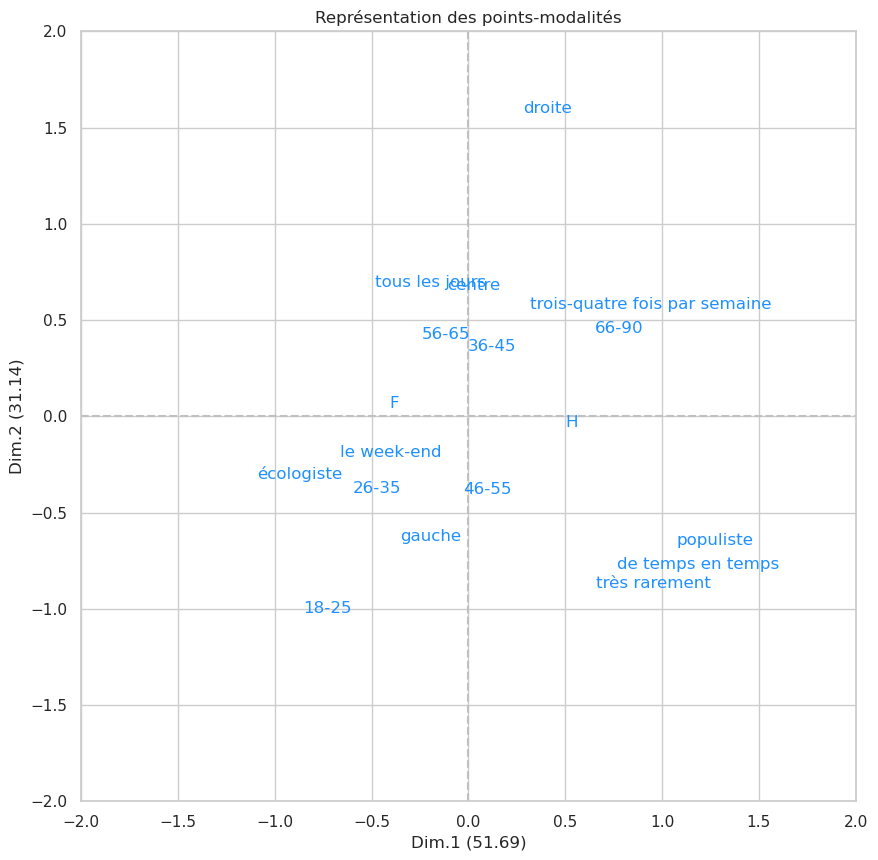

In [364]:
fix,ax = plt.subplots(figsize=(10,10))
ax.axis([-2,+2,-2,+2])
ax.plot([-2,+2],[0,0],color='silver',linestyle='--')
ax.plot([0,0],[-2,+2],color='silver',linestyle='--')
ax.set_xlabel("Dim.1 ("+ str(round(dfb.freq.iloc[0],2))+")")
ax.set_ylabel("Dim.2 ("+ str(round(dfb.freq.iloc[1],2))+")")
plt.title("Représentation des points-modalités")
for i in range(df.shape[1]):
    ax.text(acm.col_coord_[i,0],acm.col_coord_[i,1],X.columns[i],color='dodgerblue')
plt.show()

count    900.000000
mean       3.499997
std        0.690076
min        2.083700
25%        2.974800
50%        3.528400
75%        4.010400
max        5.235400
Name: dist_org, dtype: float64


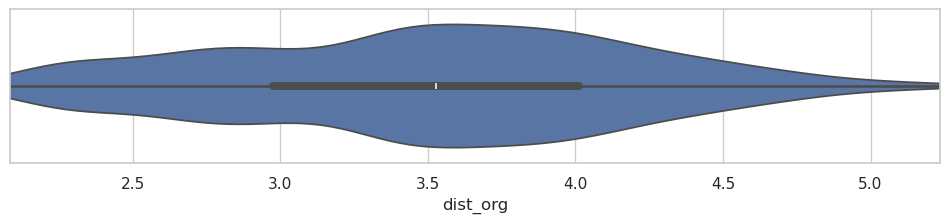

In [368]:

sns.set_theme(style="whitegrid",rc={"figure.figsize":(12,2)} )


a = X['dist_org']

print(a.describe())

# ax = sns.boxplot(x=a)
ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=min(a), right=max(a))

plt.show()

In [365]:
### Individus moyennements distants du profil moyen
sel = X[(X.dist_org>3.2) & (X.dist_org <3.7)]   ### [X.dist_org<2.5] proches du prof. m.
print(len(sel))
c_obs.loc[sel[:10].index]

249


,age,gender,revenu_mensuel,lecture_journal,parti,generation,classe_revenu
id,,,,,,,
4,26,H,3376,le week-end,écologiste,26-35,3000-4499
9,22,F,2370,tous les jours,écologiste,18-25,0-2999
11,64,H,13895,tous les jours,populiste,56-65,12000-299999
19,65,F,3042,le week-end,écologiste,56-65,3000-4499
20,60,F,4615,le week-end,centre,56-65,4500-5999
21,52,F,9622,le week-end,écologiste,46-55,8000-9999
24,63,H,5119,trois-quatre fois par semaine,populiste,56-65,4500-5999
25,72,F,3506,très rarement,gauche,66-90,3000-4499
26,89,H,6991,de temps en temps,gauche,66-90,6000-7999


In [366]:
### Récupérer la position des lignes concernées
idl = [df.index.get_loc(e) for e in sel.index.to_list()]
idl[:5]


[3, 8, 10, 18, 19]

In [347]:
### Individus très distants du profil moyen
#  donc rares
seld = X[X.dist_org>4.8]
print(len(sel))
c_obs.loc[seld[:10].index]

91


,age,gender,revenu_mensuel,lecture_journal,parti,generation,classe_revenu
id,,,,,,,
8,21,H,3338,très rarement,gauche,18-25,3000-4499
58,25,H,3658,très rarement,gauche,18-25,3000-4499
67,37,H,9286,de temps en temps,droite,36-45,8000-9999
92,39,H,5685,de temps en temps,gauche,36-45,4500-5999
113,36,F,6962,très rarement,gauche,36-45,6000-7999
266,36,H,4653,très rarement,centre,36-45,4500-5999
299,39,F,5054,très rarement,gauche,36-45,4500-5999
308,43,H,7225,de temps en temps,gauche,36-45,6000-7999
426,42,F,4257,de temps en temps,gauche,36-45,3000-4499


In [348]:
### Récupérer la position des lignes concernées
idld = [df.index.get_loc(e) for e in seld.index.to_list()]
idld[:5]


[7, 57, 66, 91, 112]

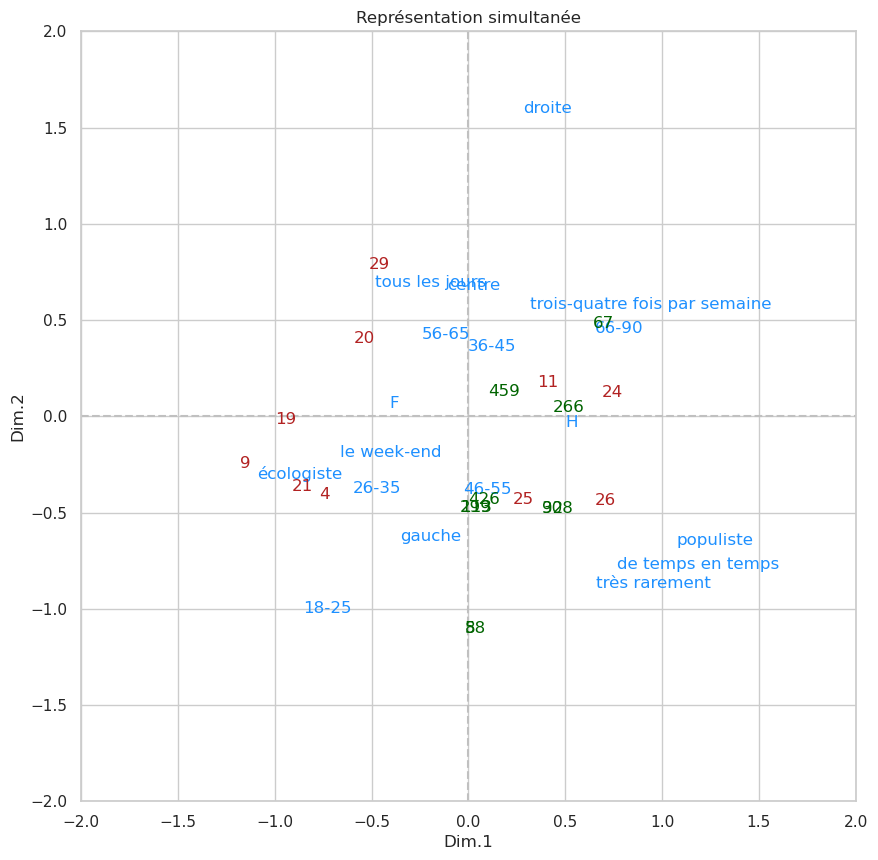

In [367]:
#représentation simultanée - relation quasi-barycentrique
fix,ax = plt.subplots(figsize=(10,10))
ax.axis([-2,+2,-2,+2])
ax.plot([-2,+2],[0,0],color='silver',linestyle='--')
ax.plot([0,0],[-2,+2],color='silver',linestyle='--')
ax.set_xlabel("Dim.1")
ax.set_ylabel("Dim.2")
plt.title("Représentation simultanée")
for i in range(df.shape[1]):
    ax.text(acm.col_coord_[i,0],acm.col_coord_[i,1],df.columns[i],color='dodgerblue')
for i in idl[:10]:
    ax.text(acm.row_coord_[i,0],acm.row_coord_[i,1],df.index[i],color='firebrick')
for i in idld[:10]:
    ax.text(acm.row_coord_[i,0],acm.row_coord_[i,1],df.index[i],color='DarkGreen')    
plt.show()

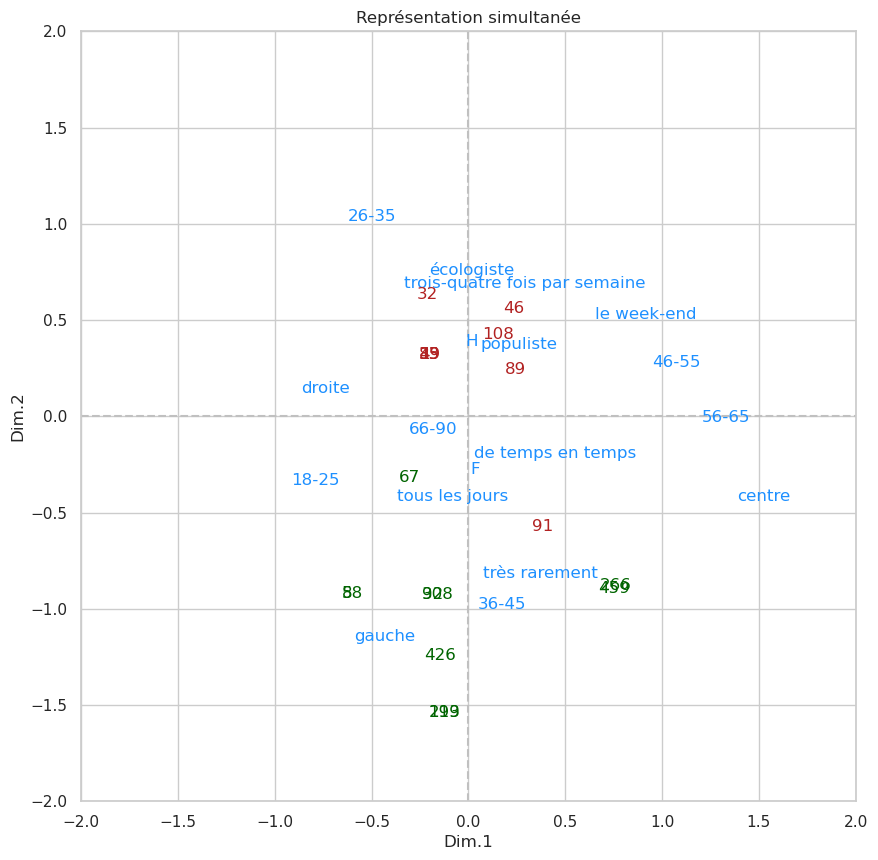

In [350]:
#représentation simultanée - relation quasi-barycentrique
fix,ax = plt.subplots(figsize=(10,10))
ax.axis([-2,+2,-2,+2])
ax.plot([-2,+2],[0,0],color='silver',linestyle='--')
ax.plot([0,0],[-2,+2],color='silver',linestyle='--')
ax.set_xlabel("Dim.1")
ax.set_ylabel("Dim.2")
plt.title("Représentation simultanée")
for i in range(df.shape[1]):
    ax.text(acm.col_coord_[i,2],acm.col_coord_[i,3],df.columns[i],color='dodgerblue')
for i in idl[:10]:
    ax.text(acm.row_coord_[i,2],acm.row_coord_[i,3],df.index[i],color='firebrick')
for i in idld[:10]:
    ax.text(acm.row_coord_[i,2],acm.row_coord_[i,3],df.index[i],color='DarkGreen')    
plt.show()

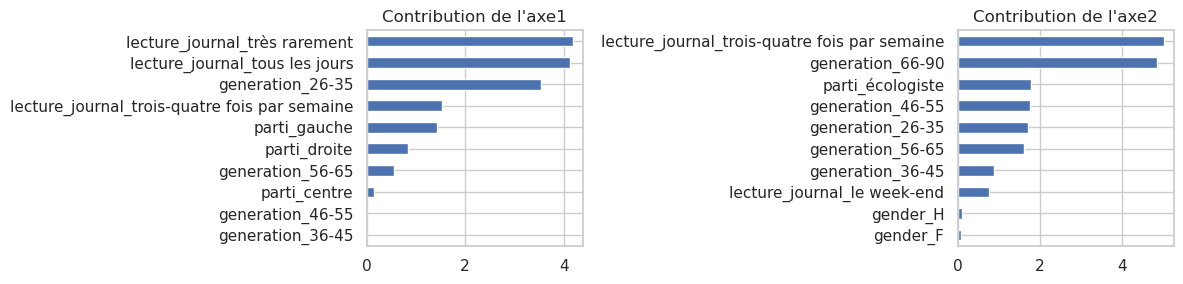

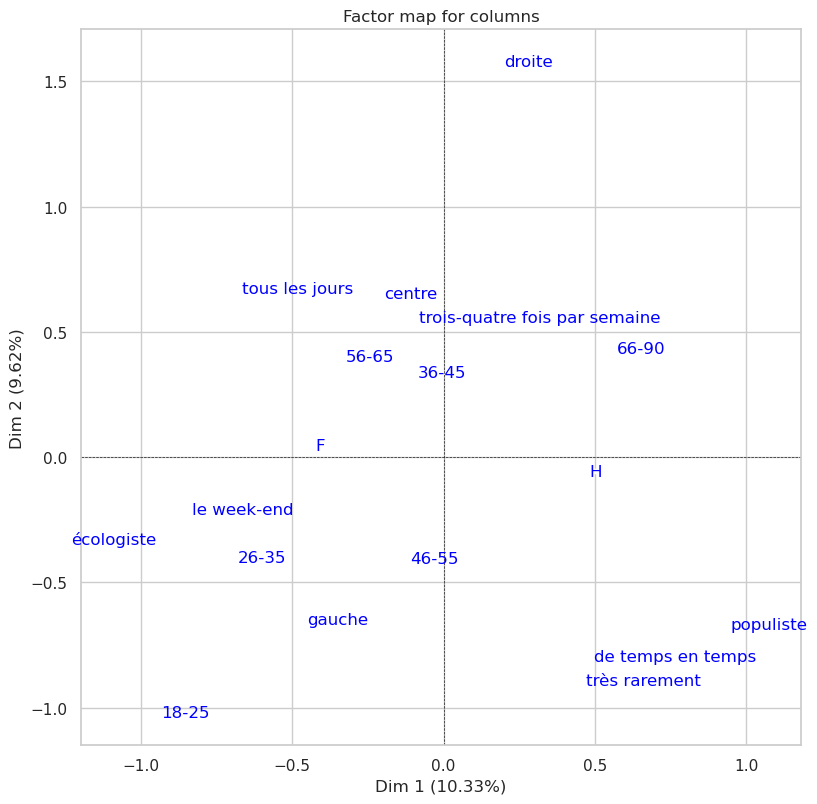

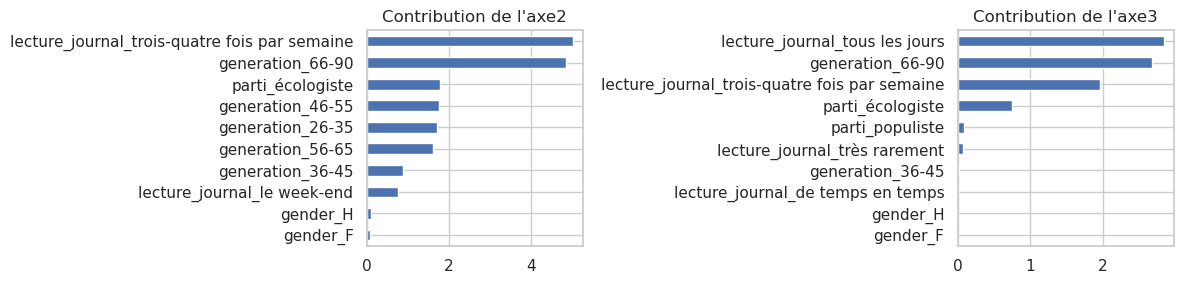

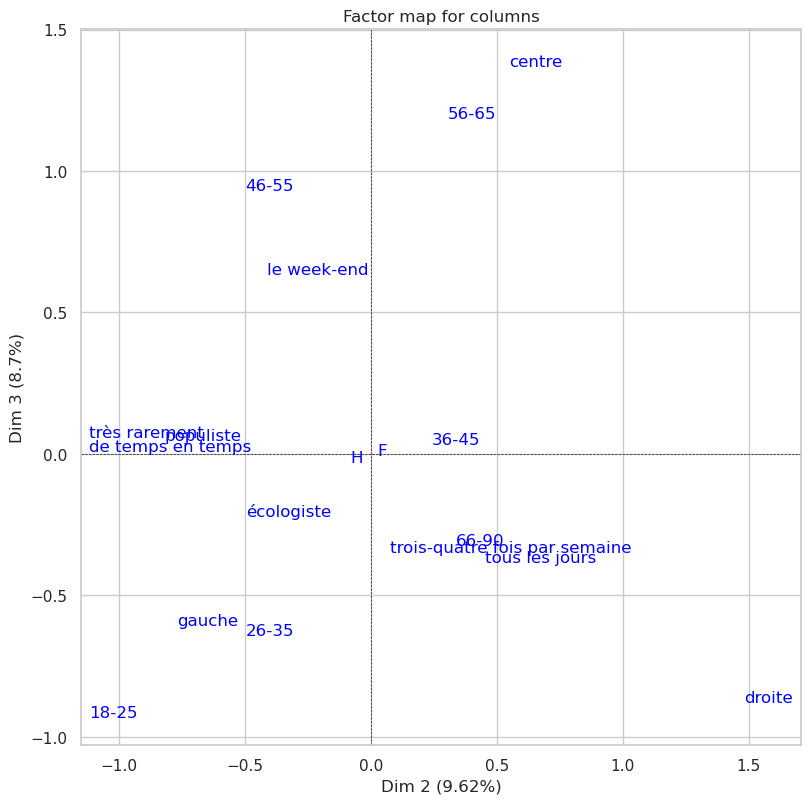

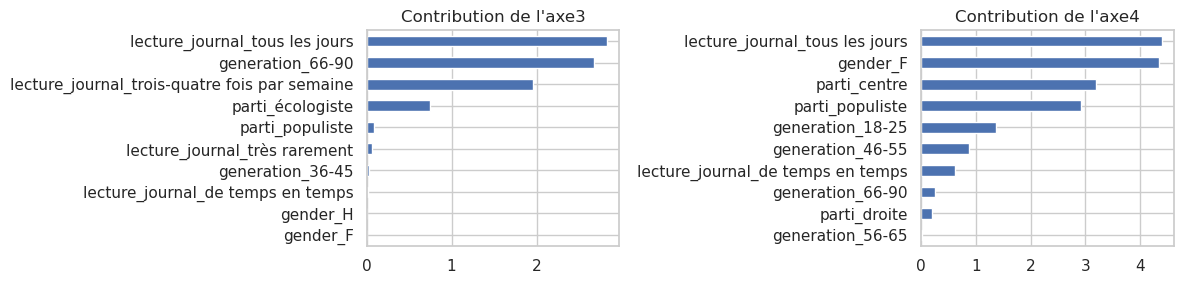

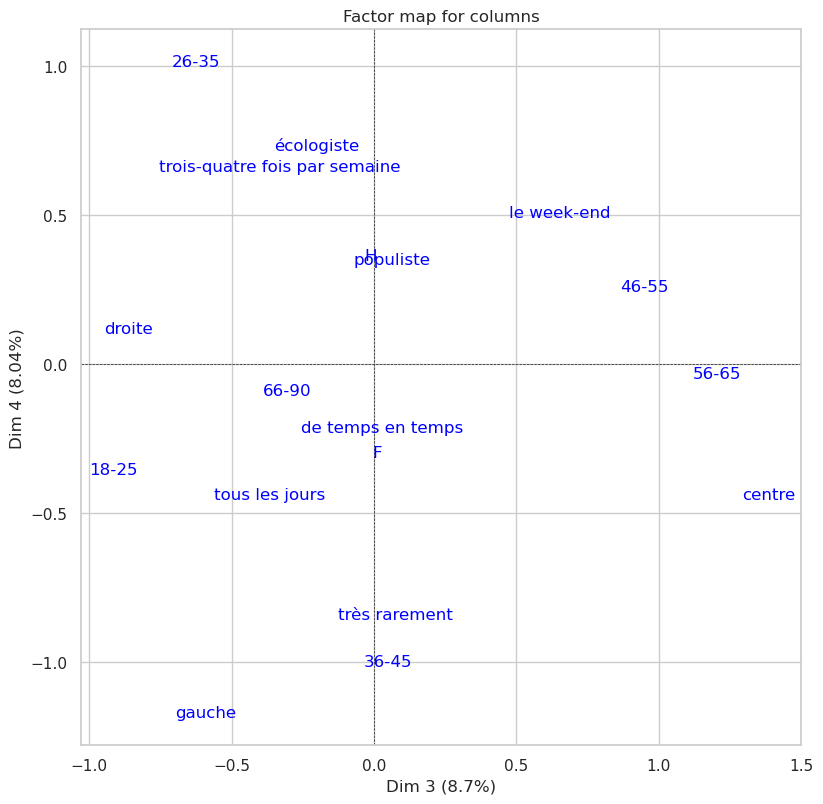

In [329]:
# Mapping des points colonnes

i = 1

### adapter le paramètre si la figure 
# est trop petite ou trop grande
param = 0.9

dfc = acm.col_topandas()

### avec la correction de Benzecri, 
# 3 axes apportent 95%  de l'information
while i < 4:    
    c1 = 'col_contrib_dim' + str(i)  
    c2 = 'col_contrib_dim' + str(1+i)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    r1 = dfc[c1].sort_values(ascending=True)[:10]
    r1.plot(kind='barh', ax=axes[0], title="Contribution de l'axe"+ str(i))

    r2 = dfc[c2].sort_values(ascending=True)[:10]
    r2.plot(kind='barh', ax=axes[1], title="Contribution de l'axe"+ str(i+1))

    plt.tight_layout()
    plt.show()

    w = eig.iloc[:,1][:i].values[0]*param
    h = eig.iloc[:,1][:(i+1)].values[0]*param
    
    acm.mapping_col(num_x_axis=i, num_y_axis=i+1, figsize=(w,h))
    plt.show()
    i +=1

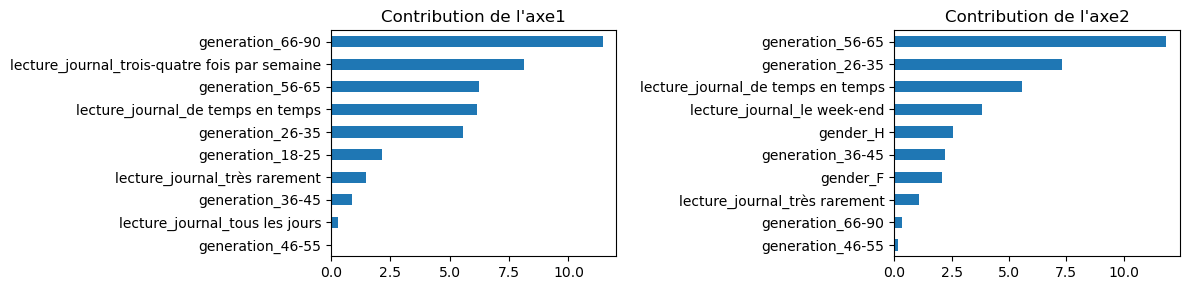

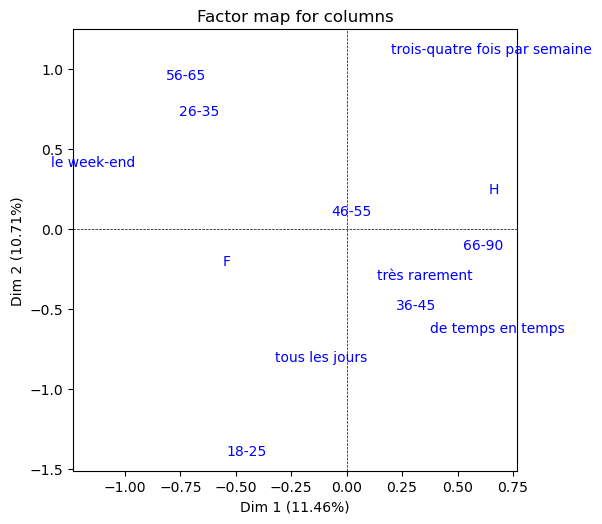

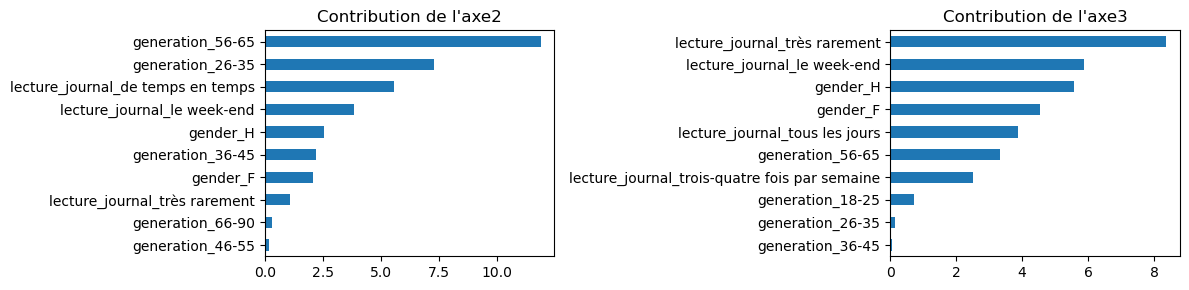

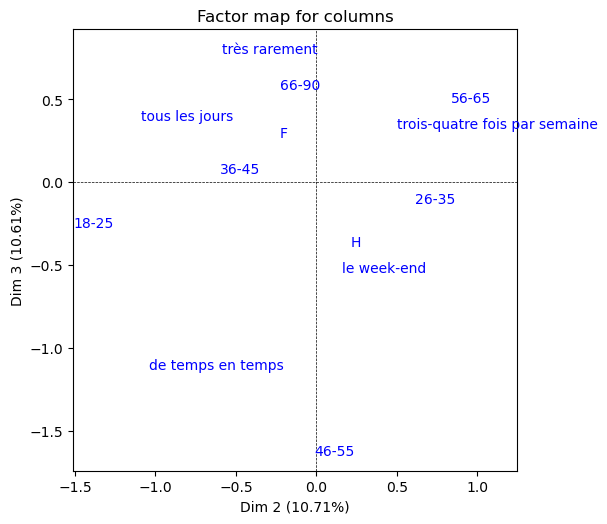

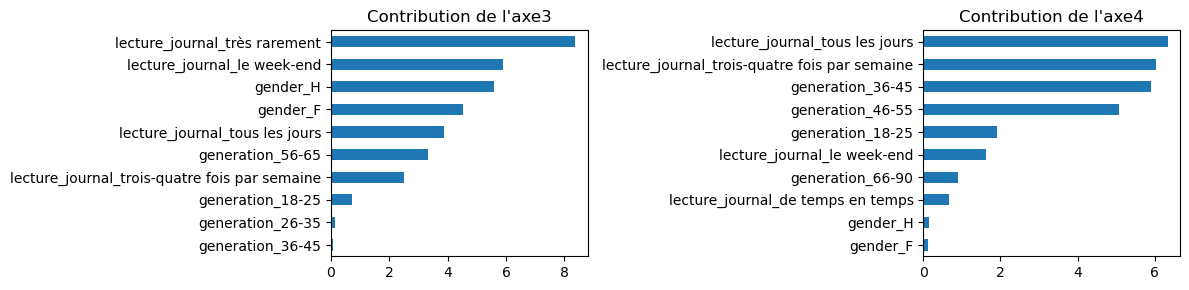

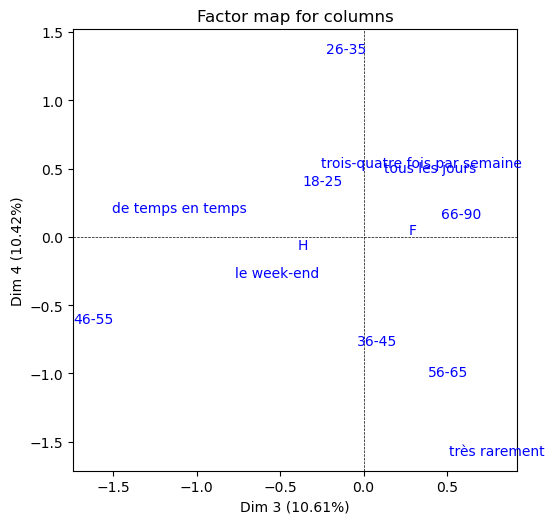

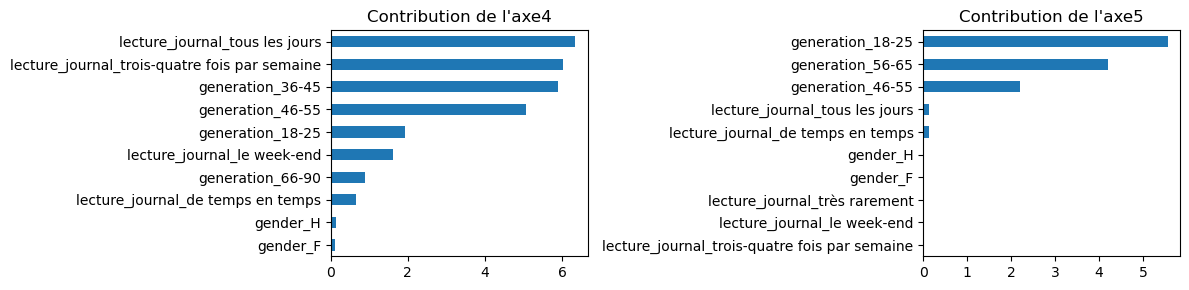

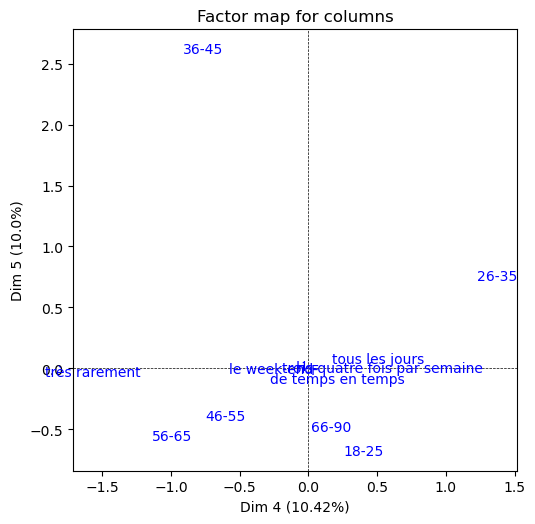

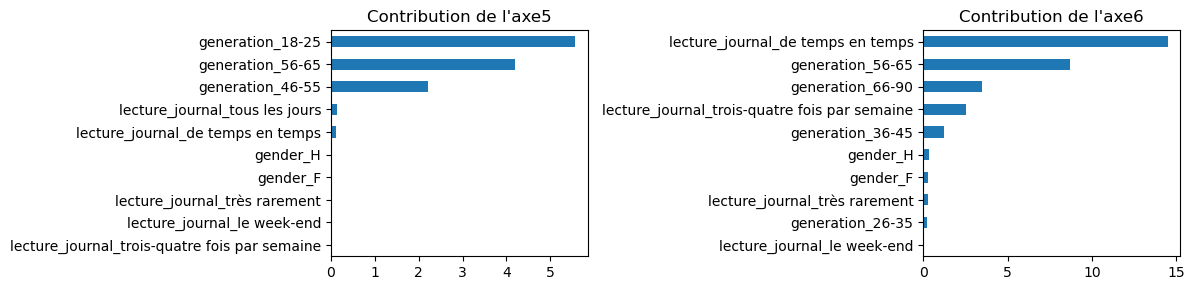

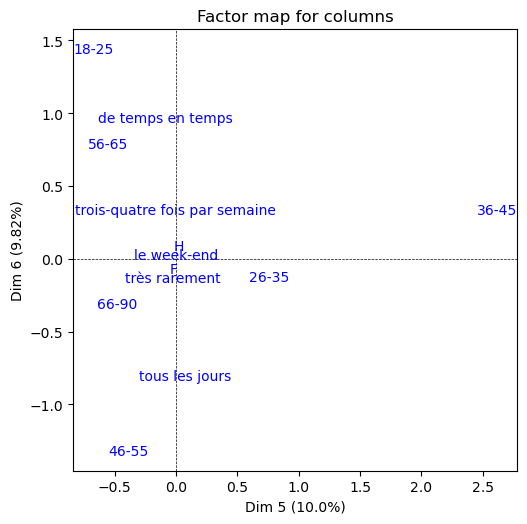

In [159]:
# Mapping des points colonnes

i = 1

### adapter le paramètre si la figure 
# est trop petite ou trop grande
param = 0.5

dfc = acm.col_topandas()


while i < 6:    
    c1 = 'col_contrib_dim' + str(i)  
    c2 = 'col_contrib_dim' + str(1+i)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    r1 = dfc[c1].sort_values(ascending=True)[:10]
    r1.plot(kind='barh', ax=axes[0], title="Contribution de l'axe"+ str(i))

    r2 = dfc[c2].sort_values(ascending=True)[:10]
    r2.plot(kind='barh', ax=axes[1], title="Contribution de l'axe"+ str(i+1))

    plt.tight_layout()
    plt.show()

    w = eig.iloc[:,1][:i].values[0]*param
    h = eig.iloc[:,1][:(i+1)].values[0]*param
    
    acm.mapping_col(num_x_axis=i, num_y_axis=i+1, figsize=(w,h))
    plt.show()
    i +=1

### Variables illustratives qualitatives

Cf. Rakotomalala, Pratique de l'analyse factorielle, 5.3.8

In [196]:
dd = pd.DataFrame(acm.row_coord_[:,:2],index=X.index,columns=['F1','F2'])
dd['classe_revenu'] = df.classe_revenu
dd.head()

,F1,F2,classe_revenu
id,,,
1,0.680688,0.158377,8000-9999
2,0.132050,-0.817786,3000-4499
3,0.680688,0.158377,6000-7999
4,-0.769125,-0.427126,3000-4499
5,0.351653,1.125949,3000-4499


In [197]:
#calcul des moyennes conditionnelles
GBar = pd.pivot_table(dd,values=['F1','F2'],index="classe_revenu",aggfunc='mean')
print(GBar)

                     F1        F2
classe_revenu                    
0-2999        -0.481079 -0.481235
10000-11999    0.157281  0.125077
12000-299999   0.114643  0.546795
3000-4499     -0.327303 -0.245700
4500-5999     -0.086722 -0.060268
6000-7999      0.214809  0.075124
8000-9999      0.199617  0.138388


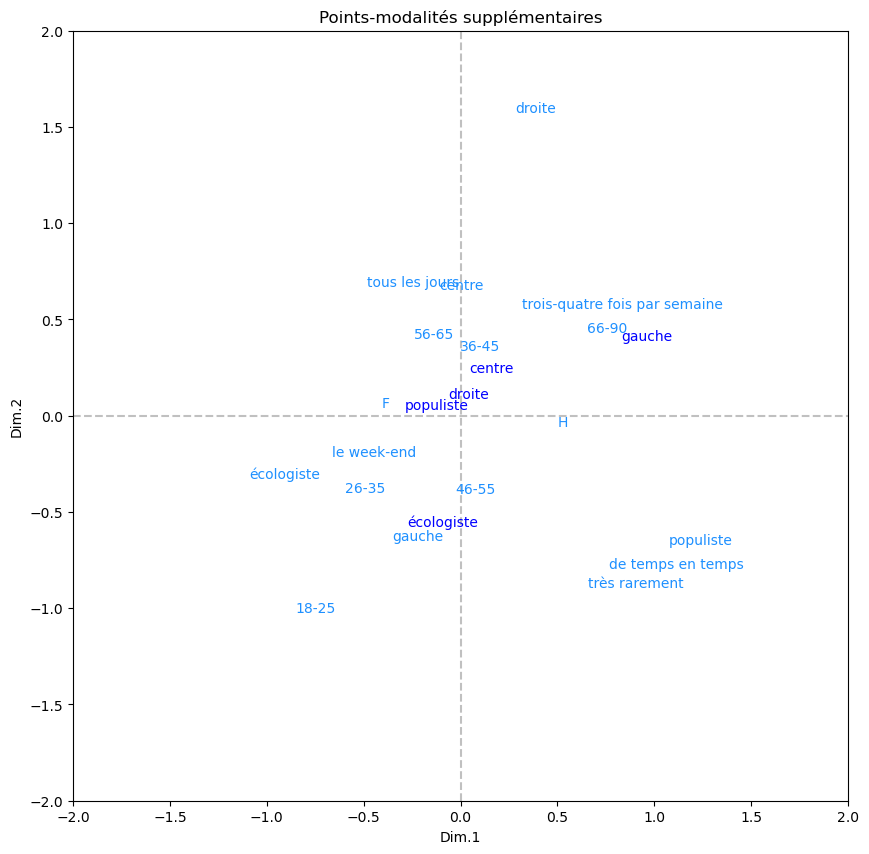

In [201]:
#représentation dans le plan
fix,ax = plt.subplots(figsize=(10,10))
ax.axis([-2,+2,-2,+2])
ax.plot([-2,+2],[0,0],color='silver',linestyle='--')
ax.plot([0,0],[-2,+2],color='silver',linestyle='--')
ax.set_xlabel("Dim.1")
ax.set_ylabel("Dim.2")
plt.title("Points-modalités supplémentaires")
#modalités actives
for i in range(X.shape[1]):
    ax.text(acm.col_coord_[i,0],acm.col_coord_[i,1],X.columns[i],color='dodgerblue')
#modalités illustratives de la variable "fonction"
for i in GBar.index:
    ax.text(GBar[GBar.index==i].values[0][0]*3,GBar[GBar.index==i].values[0][1]*3,i,color='blue')
plt.show()

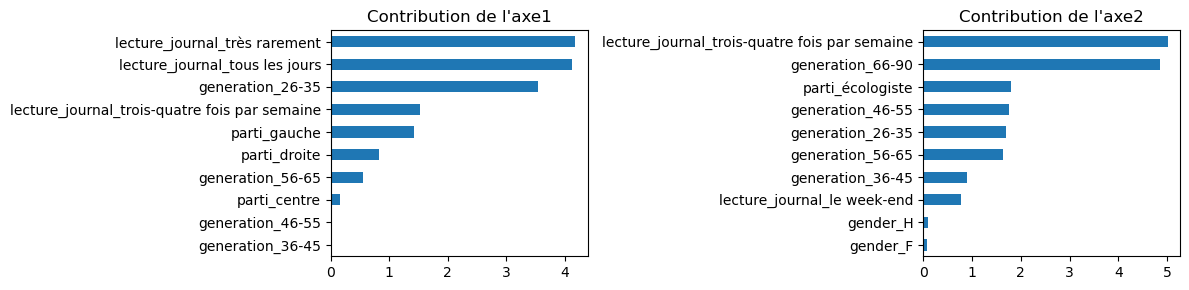

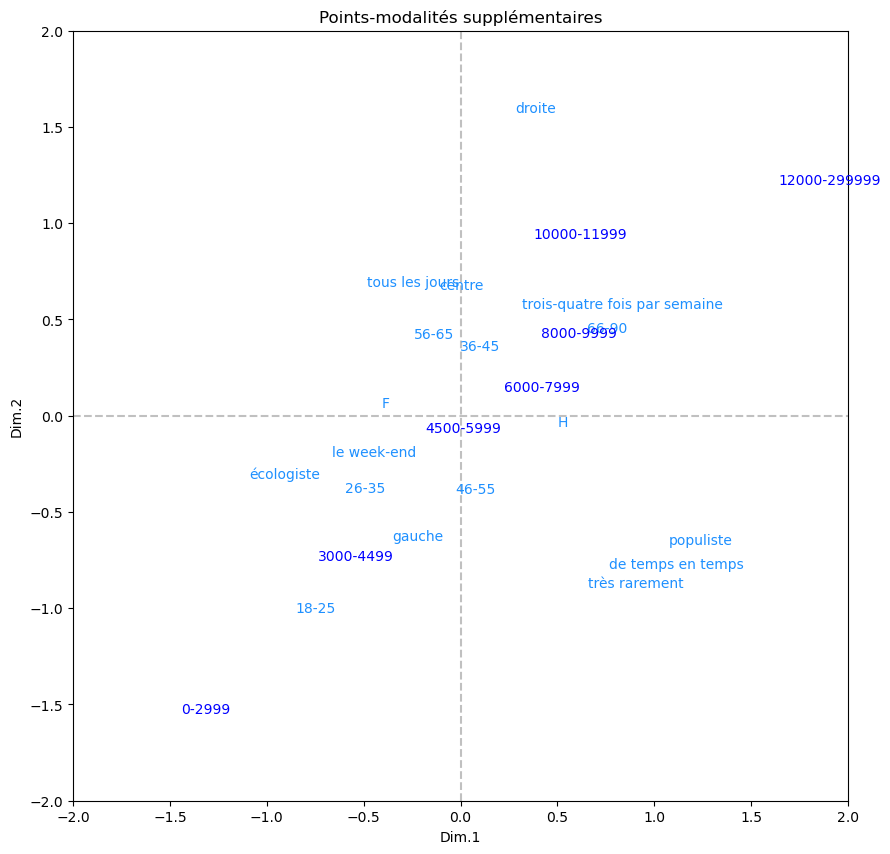

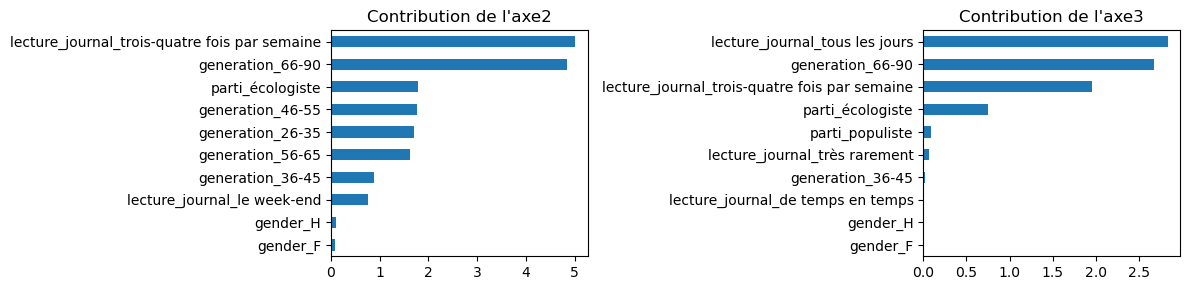

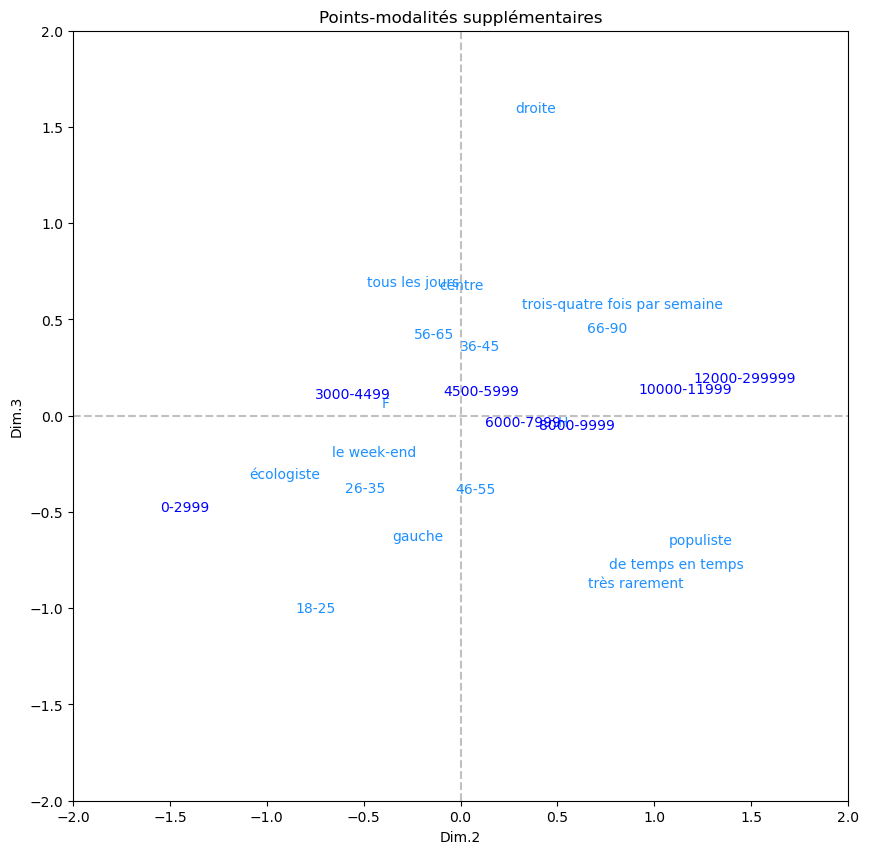

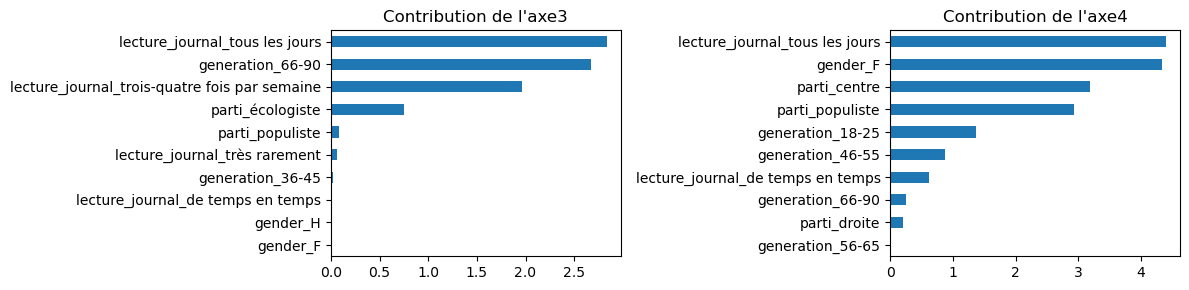

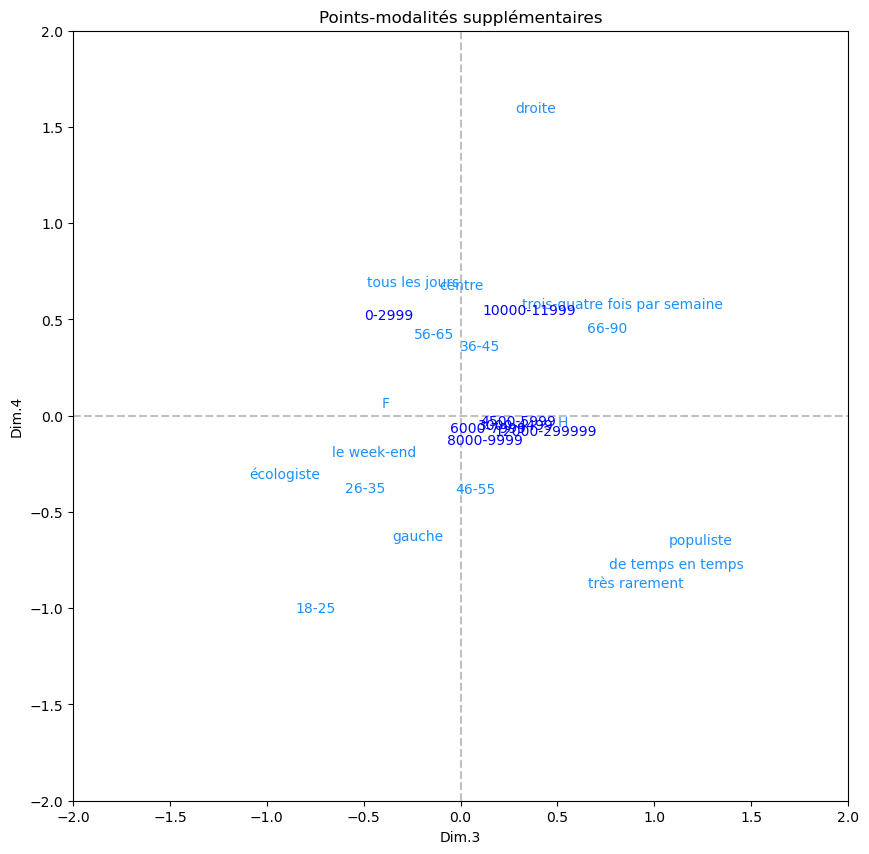

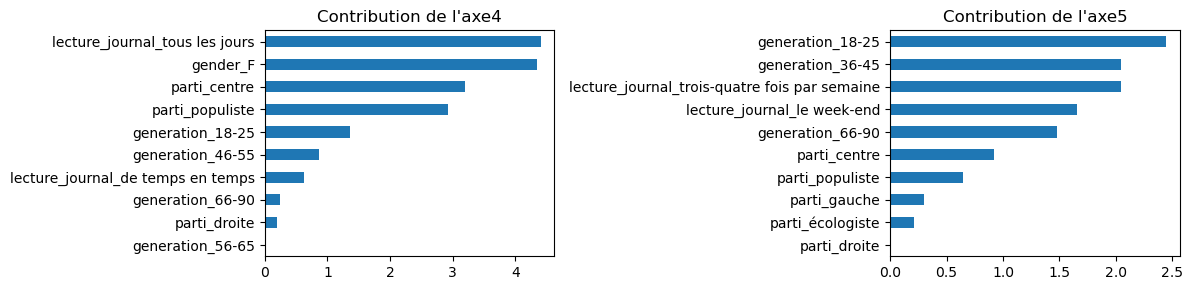

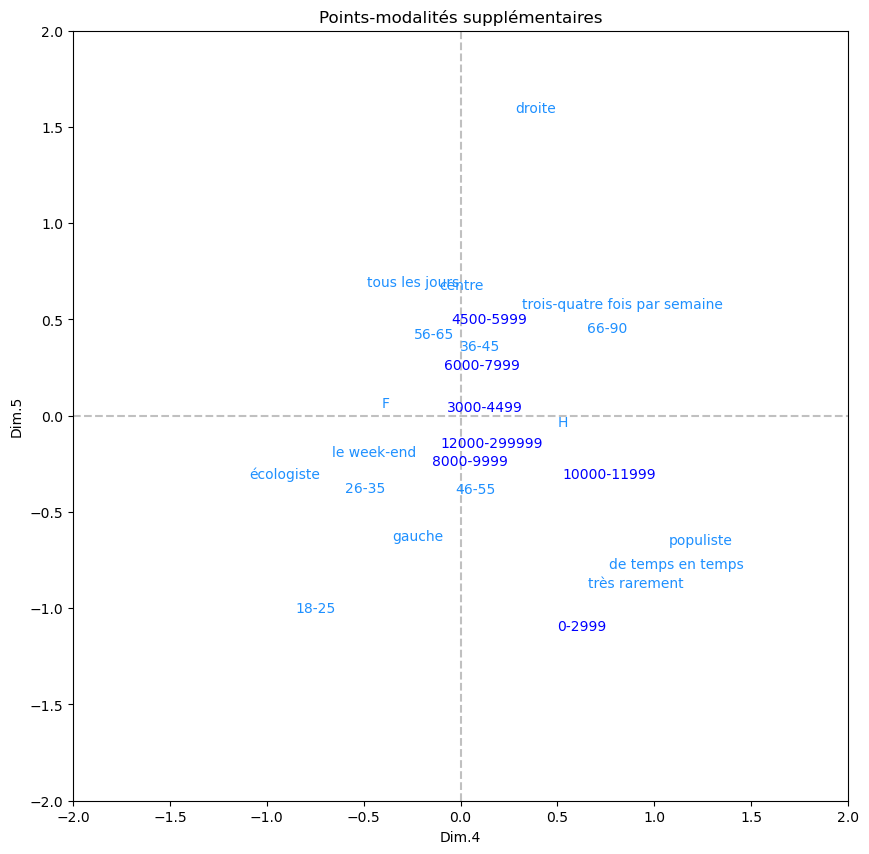

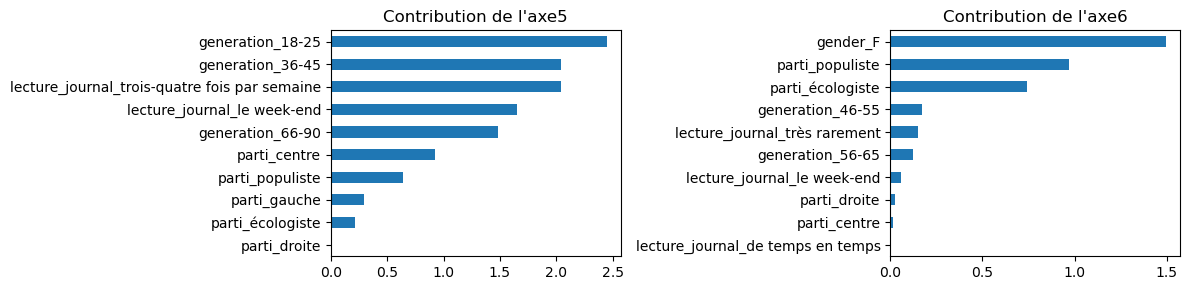

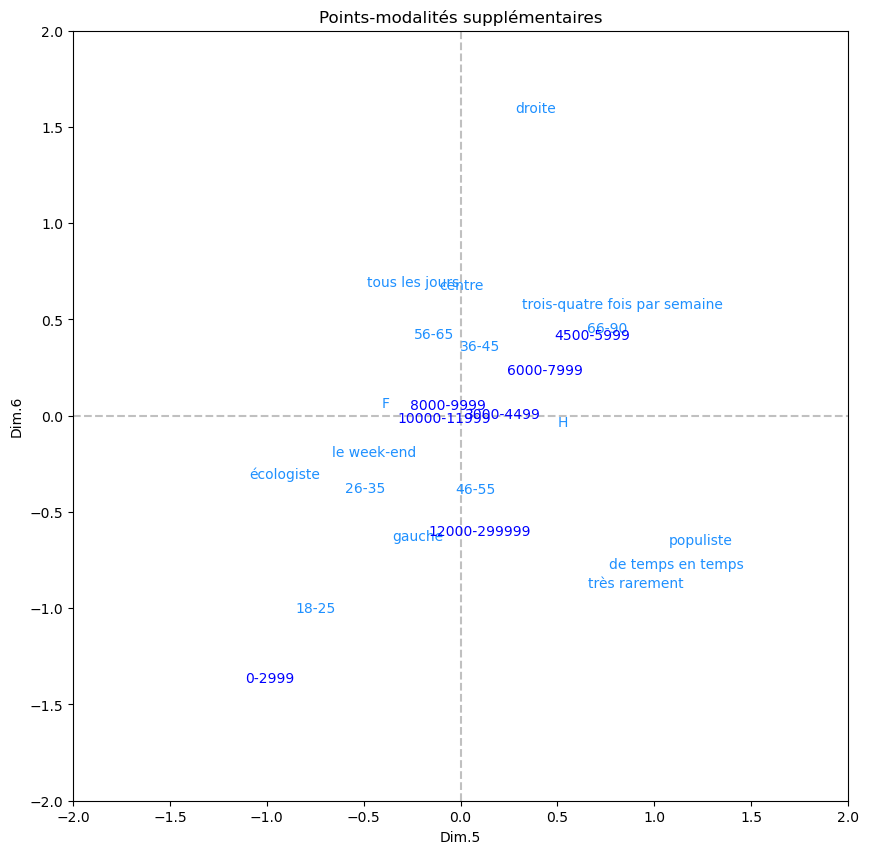

In [204]:
# Mapping des points colonnes

i = 1

### adapter le paramètre si la figure 
# est trop petite ou trop grande
param = 0.5

dfc = acm.col_topandas()


while i < 6:    
    c1 = 'col_contrib_dim' + str(i)  
    c2 = 'col_contrib_dim' + str(1+i)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    r1 = dfc[c1].sort_values(ascending=True)[:10]
    r1.plot(kind='barh', ax=axes[0], title="Contribution de l'axe"+ str(i))

    r2 = dfc[c2].sort_values(ascending=True)[:10]
    r2.plot(kind='barh', ax=axes[1], title="Contribution de l'axe"+ str(i+1))

    plt.tight_layout()
    plt.show()

    #w = eig.iloc[:,1][:i].values[0]*param
    #h = eig.iloc[:,1][:(i+1)].values[0]*param
    

    dd = pd.DataFrame(acm.row_coord_[:,i:i+2],index=X.index,columns=['F'+str(i),'F'+str(i+1)])
    dd['classe_revenu'] = df.classe_revenu
    GBar = pd.pivot_table(dd,values=['F'+str(i),'F'+str(i+1)],index="classe_revenu",aggfunc='mean')
    
    fix,ax = plt.subplots(figsize=(10,10))
    ax.axis([-2,+2,-2,+2])
    ax.plot([-2,+2],[0,0],color='silver',linestyle='--')
    ax.plot([0,0],[-2,+2],color='silver',linestyle='--')
    ax.set_xlabel("Dim."+str(i))
    ax.set_ylabel("Dim."+str(i+1))
    plt.title("Points-modalités supplémentaires")
    #modalités actives
    for e in range(X.shape[1]):
        ax.text(acm.col_coord_[e,0],acm.col_coord_[e,1],X.columns[e],color='dodgerblue')
    #modalités illustratives de la variable "fonction"
    for l in GBar.index:
        ax.text(GBar[GBar.index==l].values[0][0]*3,GBar[GBar.index==l].values[0][1]*3,l,color='blue')
    plt.show()
    i +=1